In [1]:
from numpy.random import Generator, PCG64
from numpy import unravel_index
import matplotlib.pyplot as plt
from copy import deepcopy
from random import sample
from enum import Enum
import pandas as pd
import numpy as np
import random 
random.seed(0)
import timeit
from operator import attrgetter
import math

In [2]:
import time
import multiprocessing as mp

# project packages
from models import SingleCustomer, LoadBalancer, Server, CustomerGroup, Status, Groups, ServerIDs, Statistics
from distributions import exponential_rng, homogeneous_poisson_process,\
homogeneous_poisson_process_variance_reduction

## Simulation
from simulation import handle_requests

## bootstrap
from bootstrap import bootstrap, moving_mean_var, test_bootstrap

## Scenario
from Scenario import Scenario

## utils -> get statistics
from utils import get_queue_statistics, get_statistics

## constants
from constants import MAX_CAPACITY, FIRST_ALLOCATION, SECOND_ALLOCATION

## Parameters for the simulations run: independent run, antithetic run
from SimulationParameters import SimulationParameters

## plot functions
from plot_functions import plot_queues, plot_empirical_mean_waiting_time

# Optimization Part
------------------------------------------------------------

## 1. Solution Representation
--------------------------------

In [14]:
class Solution():
    
    """
    This class provides the solution representation which
    consists of two lists: one for the movies assigned to
    ASN 1 and one for the movies assigned to ASN 2. In this
    class we also keep the performance metrics associated
    with our solution representation. We have two different
    performance metrics:
        i)  Waiting time of clients
            --> in the form of the desired statistic (average, max, or q75)
        ii) Total size in MB used in ASN 1 and ASN 2
    """
    
    def __init__(self, movies_ASN1, movies_ASN2, wt_obj):
        
        """
        % Constructor
        
        @inputs:
        --------
        
        --> movies_ASN1: list, movies stored in ASN 1
        --> movies_ASN2: list, movies stored in ASN 2
        --> wt_obj: string, the desired waiting time statistic (average, max, or q75)
        """
        
        self.movies_ASN1 = movies_ASN1  
        self.movies_ASN2 = movies_ASN2
        self.scenario = Scenario(self.movies_ASN1, self.movies_ASN2)  # the link with the simulation part
        self.total_size = sum([self.scenario.movie_sizes[i] for i in self.movies_ASN1])
        self.total_size += sum([self.scenario.movie_sizes[i] for i in self.movies_ASN2])
        
        # Yoooooooooo, that's a lot!
        _, self.statistics = antithetic_runs(
            allocation=self.movies_ASN1, # dummy variable if scenario is specified
            scenario=self.scenario # for compatibility between simulation and optimization
        ) 
        
        self.wt_obj = wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]  # desired statistic
        
        # let's keep all statistics (average, max, 75) associated with the solution
        self.waiting_time_max = self.statistics['overall']['max']
        self.waiting_time_q75 = self.statistics['overall']['q75']
        self.waiting_time_average = self.statistics['overall']['average']

    def get_objectives(self):
        
        """
        % Returns the performance metrics we have.
        
        @inputs:
        --------
        
        --> None
        
        @outputs:
        ---------
        
        --> a tuple of two elements.
        
        Warning: 
        -------
        The second performance metric (objective), i.e.,
        total size, is only used in multi-objective opt.
        """
        
        return self.waiting_time, self.total_size
    
    def set_movies_ASN1(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 1
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 1
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN1 = new_movies
    
    def set_movies_ASN2(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 2
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 2
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN2 = new_movies
    
    def change_wt_obj(self, new_wt_obj):
        
        """
        % It changes the desired statistic of waiting time
        as given in the argument.
        
        @inputs:
        --------
        
        --> new_wt_obj: string, ("average", "max", or "q75")
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.wt_obj = new_wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]

## 2. Initial Solution
----------------------------------------

In [15]:
def get_min_size_left(movie_ls):
    
    """
    % It returns the minimum movie size of the movies
    which are not placed in the given list of the movies
    as an argument.
    
    @inputs:
    --------
    
    --> movie_ls: list, list of movies
    
    @outputs:
    ---------
    
    --> integer
    """
    
    scenario = Scenario([], [])  # null scenario to reach some problem parameters (like movie sizes)
    left_movies = list(set(list(range(10))) - set(movie_ls))  # list of movies that are not placed
    return min([scenario.movie_sizes[i] for i in left_movies])  # the minimum size among them

def constructionHeuristic(wt_obj):
    
    """
    % This function applies a construction heuristic which tries to 
    assign most popular film-group combinations to appropriate servers
    considering the distance between selected groups and servers.
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    popularity = np.array(deepcopy(scenario.popularities))
    while True:
        group_, movie_ = unravel_index(popularity.argmax(), popularity.shape)
        if popularity[group_, movie_]<0:  # it means that we examined all group-movie pairs.
            break                         # therefore, we can terminate the loop
        popularity[group_, movie_] = - 1  # not to draw the same argmax indexes again and again
        group_obj = None
        if group_ == 0:
            group_obj = CustomerGroup(Groups.Group_1.value, scenario.popularities[0],
                                      scenario.activity_patterns[0], scenario.distances_g1)
        elif group_ == 1:
            group_obj = CustomerGroup(Groups.Group_2.value, scenario.popularities[1],
                                      scenario.activity_patterns[1], scenario.distances_g2)
        elif group_ == 2:
            group_obj = CustomerGroup(Groups.Group_3.value, scenario.popularities[2],
                                      scenario.activity_patterns[2], scenario.distances_g3)
        best_server = group_obj.best_server_options()[0]  # find the best server considering the distances
        if best_server == 'ASN1' and size1+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies1:
            movies1.append(movie_)
            size1 += scenario.movie_sizes[movie_]
        if best_server == 'ASN2' and size2+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies2:
            movies2.append(movie_)
            size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

def getRandomFeasibleSolution(wt_obj):
    
    """
    % Generates a random feasible solution
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    while True:
        rand_ = random.uniform(0,1)  # to determine which ASN will be considered in the current iteration
        if rand_<=0.5:  # ASN 1
            movie_ = random.choice(list(set(list(range(10))) - set(movies1)))  # random movie for ASN 1
            if size1+scenario.movie_sizes[movie_]<=3500:
                movies1.append(movie_)
                size1 += scenario.movie_sizes[movie_]
        else:
            movie_ = random.choice(list(set(list(range(10))) - set(movies2)))  # random movie for ASN 2 
            if size2+scenario.movie_sizes[movie_]<=3500:
                movies2.append(movie_)
                size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

## 3. Neighborhood Definitions
----------------------------------

In [16]:
def generateNewMovie_1(rg, movie_list):
    #From the starting point, randomly choose 1 movie to delete, 
    #Randomly choose 2, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    del new_movie_list[c1]

    # choose another two
    c1 = -1
    c2 = -1
    
    while ((c1 == -1) or (c2 == -1) or (c1 == c2) or (c1 in movie_list) or (c2 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_1(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_1"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_1(rg, movies_1)
    new_movies_2 = generateNewMovie_1(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [17]:
def generateNewMovie_2(rg, movie_list):
    #From the starting point, randomly choose 2 movies to delete, 
    #Randomly choose 3, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
        if c2 > c1:
            del new_movie_list[c2]
            del new_movie_list[c1]
        else:
            del new_movie_list[c1]
            del new_movie_list[c2]

    # choose another three
    c1 = -1
    c2 = -1
    c3 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_2(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_2"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_2(rg, movies_1)
    new_movies_2 = generateNewMovie_2(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [18]:
def generateNewMovie_3(rg, movie_list):
    #From the starting point, randomly choose 3 movies to delete, 
    #Randomly choose 4, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
    
        if n_new_movie > 2:
            c3 = rg.choice(range(0, n_new_movie))
            while ((c3 == c1) or (c3 == c2)):
                c3 = rg.choice(range(0, n_new_movie))
        
            for ele in sorted([c1,c2,c3], reverse = True): 
                del new_movie_list[ele]
        else:
            if c2 > c1:
                del new_movie_list[c2]
                del new_movie_list[c1]
            else:
                del new_movie_list[c1]
                del new_movie_list[c2]

    # choose another four
    c1 = -1
    c2 = -1
    c3 = -1
    c4 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1) or (c4 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3) or (c1 == c4) or (c2  == c4) or (c3 == c4)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list) or (c4 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
        c4 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
            else:
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_3(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_3"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_3(rg, movies_1)
    new_movies_2 = generateNewMovie_3(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [19]:
def binary_change(movie_list, i):
    
    """
    % Checks whether given movie is placed in the given
    movie list or not. If given remove it, otherwise adds it 
    unless it does not violate the feasibility (capacity constraint).
    
    @Input:
    -------
    movie_list: List, movie lists
    i: int, specific movie
    movie_sizes: dict
    
    @Output:
    --------
    A list
    """
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]
    new_movie_list = deepcopy(movie_list)
    if i in new_movie_list:
        new_movie_list.remove(i)
    else:
        new_movie_list.append(i)
    
    if sum([movie_sizes[movie] for movie in new_movie_list]) > 3500:
        return movie_list
    else:
        return new_movie_list

def get_neighbor_4(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_4"
    
    @ outputs:
    ----------
    Solution object
    """
    movie_1, movie_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    sample1 = random.sample(movie_2, min(len(movie_2), 2))
    sample2 = random.sample(movie_1, min(len(movie_1), 2))
    best_neighbor, best_neighbor_val = None, np.inf
    for i in sample1:
        new_movie_1 = binary_change(movie_1, i)
        for j in sample2:
            new_movie_2 = binary_change(movie_2, j)
            candidate = Solution(new_movie_1, new_movie_2, current_sol.wt_obj)
            candidate_val, _ = candidate.get_objectives()
            if candidate_val < best_neighbor_val:
                best_neighbor, best_neighbor_val = candidate, candidate_val
    if best_neighbor is not None:
        return best_neighbor
    else:
        return current_sol

## 4. Single objective
------------------------------------------------------------------------------------------------------------------

### 4.1. Helpers

In [20]:
def temperature_update(init, i, iterations):
        """
        % It returns an updated version of the 
        temperature value
        
        @inputs:
        --------
        --> init: float, initial temperature value
        --> i: int, current iterations number
        --> iterations: int, total number of iterations
        
        @outputs:
        ---------
        --> updated temperature value, float
        """
        p_0 = 0.999
        p_f = 0.001
        return -init/np.log(p_0+(p_f-p_0)/iterations*i)

In [21]:
def get_candidate_solution(rg, given_solution, which_neighbor):
    """
    % It generates a neighborhood of the given solution with respect to
      the desired neighborhood definition.
      
    @inputs:
    --------
    rg: random number generator
    given solution: Solution object, current solution
    which_neighbor: int, desired neighborhood definition
                    1 --> neighborhood definition 1
                    2 --> neighborhood definition 2
                    3 --> neighborhood definition 3
                    4 --> neighborhood definition 4
    wt_obj: string, ("average", "max", or "q75")
    
    @output:
    --------
    Solution object, neighborhood solution
    """
    
    if which_neighbor == 1:
        return get_neighbor_1(rg, given_solution)
    elif which_neighbor == 2:
        return get_neighbor_2(rg, given_solution)
    elif which_neighbor == 3:
        return get_neighbor_3(rg, given_solution)
    elif which_neighbor == 4:
        return get_neighbor_4(rg, given_solution)
    else:
        raise ValueError("Should be 1,2,3, or 4!")

### 4.2. Base Class

In [22]:
class AlgorithmSingleObjective(object):

    """
    This class provides basis for the
    algorithms used in  single-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        self.best_solution = deepcopy(self.initial_solution)
        self.best_value, _ = self.initial_solution.get_objectives()
        self.algorithm_name = None
        self.time = None
        
        self.history_bestsol = []      # keeps track of best solutions over the iterations
        self.history_currentsol = []   # keeps track of current solutions over the iterations
        self.history_candidatesol = [] # keeps track of candidate solutions over the iterations
        
        # keep all statistics associated with the best found solution
        self.best_value_max = None
        self.best_value_average = None
        self.best_value_q75 = None
        # the three statistics above will be updated once the algorithm
        # returns its best found solution

### 4.3. Local Search

In [23]:
class LocalSearch(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearch"
    
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, self.best_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            if candidate_value < self.best_value:
                self.best_solution = candidate_solution
                self.best_value = candidate_value
            self.history_bestsol.append(self.best_value)
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
    
    def plot_ls(self, which_neighbor, which_run=None, randomm_init_sol=False):
      
        """
        Plots the history of local search.
        """
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Candidate Solution Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "Local Search with Neighborhood Definition " + str(which_neighbor)
        else:
            title_ = "Local Search with Neighborhood Definition " + str(which_neighbor) + " & Random Initial Solution"
        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/local_search_experiment/"
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "ls_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "ls_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_ls_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "rnd_ls_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        plt.savefig(dir_)

### 4.4. Simulated Annealing

In [24]:
class SimulatedAnnealing(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Simulated Annealing
    """
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, temp_init=1):
        
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> temp_init: float (optinal), initial temperature value
        """
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.temp_init = temp_init
        self.algorithm_name = "SimulatedAnnealing"
    
    def run(self, which_neighbor):
        
        """
        Runs the simulated annealing algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        
        start_time = timeit.default_timer()
        current_solution = deepcopy(self.initial_solution)
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, current_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            current_temperature = temperature_update(self.temp_init, i, self.n_iteration)
            diff = candidate_value - self.best_value
            
            if diff<0:  # then update both best found solution and the current solution
                current_solution = deepcopy(candidate_solution)
                self.best_solution = deepcopy(candidate_solution)
                self.best_value = candidate_value
            else:
                if self.rg.random() < np.exp(-diff/current_temperature):  # then only update the current solution
                    current_solution = deepcopy(candidate_solution)
            self.history_bestsol.append(self.best_value)
            self.history_currentsol.append(current_solution.get_objectives()[0])
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
        
    def plot_sa(self, which_neighbor, which_run=None, randomm_init_sol=False):
        """
        Plots the history of simulated annealing.
        """
        
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax.plot(iterations, self.history_currentsol, color='green', label='Current Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "Simulated Annealing with Neighborhood Definition " + str(which_neighbor)
        else:
            title_ = "Simulated Annealing with Neighborhood Definition " + str(which_neighbor) + " & Random Initial Solution"
        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/simulated_annealing_experiment/"
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "sa_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "sa_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_sa_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "rnd_sa_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        plt.savefig(dir_)


### 4.5. Variable Neighborhood Search (VNS)

In [25]:
class VNS(AlgorithmSingleObjective):
    """
    Inherited from AlgorithmSingleObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int (optinal)
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNS"
        self.history_k = []
    
    def run(self):
        """
        % Runs VNS
        """
        
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                # print('iter: ', n_iter, 'k', k)
                best_candidate = get_candidate_solution(self.rg, self.best_solution, k)
                best_candidate_val,_ = best_candidate.get_objectives()
                n_iter +=1
                self.history_candidatesol.append(best_candidate_val)
                self.history_k.append(k)
                if best_candidate_val < self.best_value:
                    self.best_solution = best_candidate
                    self.best_value = best_candidate_val
                    self.history_bestsol.append(self.best_value)
                else:
                    self.history_bestsol.append(self.best_value)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        self.best_value_max = self.best_solution.waiting_time_max
        self.best_value_average = self.best_solution.waiting_time_average
        self.best_value_q75 = self.best_solution.waiting_time_q75
                
    def plot_vns(self, which_run=None, randomm_init_sol=False):
        
        """
        Plots the history of VNS.
        """
        
        iterations = list(range(1, self.n_iteration+1))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax.set_xticks(list(range(1, self.n_iteration+1)))
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='o')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax2.set_ylabel("Best Solution Objective Function Value", fontsize=12)
        if randomm_init_sol is False:
            title_ = "VNS"
        else:
            title_ = "VNS with Random Initial Solution"

        plt.title(title_, fontsize=16)
        dir_ = "plots/optimization/vns_experiment/"
        
        
        if randomm_init_sol is False:
            if which_run is None:
                dir_ += "vns.pdf"
            else:
                dir_ += "vns_" + str(which_run) + ".pdf"
        else:
            if which_run is None:
                dir_ += "rnd_vns.pdf"
            else:
                dir_ += "rnd_vns_" + str(which_run) + ".pdf"
            
        plt.savefig(dir_)

## 5.Multi-objective Optimization
--------------------------------------------------------------------------------------------

### 5.1. Helpers

In [26]:
# Pareto dominance
def improvement(solution_old, solution_new):
    
    """
    % It checks whether new solution dominates
    the old solution or not
    
    @inputs:
    --------
    --> solution_old: Solution object, old solution
    --> solution_new: Solution object, new solution
    
    @outputs:
    --------
    --> true if new solution dominates; false, otherwise
    """
    rule_1, rule_2 = False, False
    
    waiting_time_old, total_size_old = solution_old.get_objectives()
    waiting_time_new, total_size_new = solution_new.get_objectives()
    
    if waiting_time_new <= waiting_time_old and total_size_new <= total_size_old:
        rule_1 = True
        
    if waiting_time_new < waiting_time_old or total_size_new < total_size_old:
        rule_2 = True

    return rule_1 and rule_2

### 5.2. Base Class

In [27]:
class AlgorithmMultiObjective(object):

    """
    This class provides basis for the
    algorithms used in  multi-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        
        self.algorithm_name = None
        self.time = None
        
        self.pareto_frontier = [deepcopy(self.initial_solution)]
        self.considered = []
        self.removed = []
        
    def plot(self, which_neighbor=None, which_run=None):
        """
        % plots history of multi-objective optimization algorithm
        """
        plt.figure(figsize=(12,7))
        plt.scatter([sol.total_size for sol in self.considered],
                    [sol.waiting_time for sol in self.considered],
                    label="considered", c='blue',s=50)
        plt.scatter([sol.total_size for sol in self.pareto_frontier],
                    [sol.waiting_time for sol in self.pareto_frontier],
                    label="Pareto", c='red', s=50)  
        plt.scatter([sol.total_size for sol in self.removed],
                    [sol.waiting_time for sol in self.removed],
                    label="Removed", c='orange', s=50) 
        plt.xlabel("Total Size")
        plt.ylabel("Waiting Time")
        plt.legend()
        if self.algorithm_name == "LocalSearchMultiObj":
            plt.title("Local Search with Neighborhood Definition " + str(which_neighbor), fontsize=16)
            dir_ = "plots/optimization/multiobjective/local_search_experiment/"
            if which_run is None:
                dir_ += "mols_" + str(which_neighbor) + ".pdf"
            else:
                dir_ += "mols_" + str(which_neighbor) + "_" + str(which_run) + ".pdf"
        elif self.algorithm_name == "VNSMultiObj":
            plt.title("Variable Neighborhood Search", fontsize=16)
            dir_ = "plots/optimization/multiobjective/vns_experiment/"
            if which_run is None:
                dir_ += "movns.pdf"
            else:
                dir_ += "movns_" + str(which_run) + ".pdf"
        plt.savefig(dir_)


### 5.3. Local Search

In [28]:
class LocalSearchMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearchMultiObj"
        
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            x = random.choice(self.pareto_frontier)
            candidate_solution = get_candidate_solution(self.rg, x, which_neighbor)
            if candidate_solution in self.pareto_frontier:
                continue
            D = [i for i in self.pareto_frontier if improvement(i, candidate_solution)]
            S = [i for i in self.pareto_frontier if improvement(candidate_solution, i)]
            if len(S)==0:
                self.pareto_frontier.append(candidate_solution)
                for i in D:
                    self.pareto_frontier.remove(i)
                    self.removed.append(i)
            else:
                self.considered.append(candidate_solution)
        end_time = timeit.default_timer()
        self.time = end_time - start_time

### 5.4. VNS

In [29]:
class VNSMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int, optional
        """
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNSMultiObj"
        self.history_k = []
    
    def run(self):
        
        """
        Runs VNS for multi-objective case
        """
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                print('iter: ', n_iter, 'k', k)
                x = random.choice(self.pareto_frontier)
                candidate = get_candidate_solution(self.rg, x, k)
                if candidate in self.pareto_frontier:
                    continue
                candidate_val,_ = candidate.get_objectives()
                n_iter +=1
                self.history_k.append(k)
                D = [i for i in self.pareto_frontier if improvement(i, candidate)]
                S = [i for i in self.pareto_frontier if improvement(candidate, i)]
                if len(S)==0:
                    self.pareto_frontier.append(candidate)
                    for i in D:
                        self.pareto_frontier.remove(i)
                        self.removed.append(i)
                else:
                    self.considered.append(candidate)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time

# Experiments

## Comparing Different Objectives

### For single objectives

In [30]:
# init_sol = getRandomFeasibleSolution("average")
# rg_ = Generator(PCG64(42069))
# n_iteration = 5

#### Local Search

In [31]:
"""
local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
local_search_average.run(which_neighbor=1)

init_sol.change_wt_obj("max")
local_search_max = LocalSearch(rg_, init_sol, n_iteration, wt_obj='max')
local_search_max.run(which_neighbor=1)

init_sol.change_wt_obj("q75")
local_search_q75 = LocalSearch(rg_, init_sol, n_iteration, wt_obj='q75')
local_search_q75.run(which_neighbor=1)
"""

'\nlocal_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'average\')\nlocal_search_average.run(which_neighbor=1)\n\ninit_sol.change_wt_obj("max")\nlocal_search_max = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'max\')\nlocal_search_max.run(which_neighbor=1)\n\ninit_sol.change_wt_obj("q75")\nlocal_search_q75 = LocalSearch(rg_, init_sol, n_iteration, wt_obj=\'q75\')\nlocal_search_q75.run(which_neighbor=1)\n'

In [32]:
"""
x = {'Average':[local_search_average.best_value_average,
                local_search_max.best_value_average,
                local_search_q75.best_value_average],
     'Max':[local_search_average.best_value_max,
            local_search_max.best_value_max,
            local_search_q75.best_value_max,],
     'Q75': [local_search_average.best_value_q75,
             local_search_max.best_value_q75,
             local_search_q75.best_value_q75]}

LS_Objs = pd.DataFrame(x)
LS_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m Local Search \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(LS_Objs)
"""

'\nx = {\'Average\':[local_search_average.best_value_average,\n                local_search_max.best_value_average,\n                local_search_q75.best_value_average],\n     \'Max\':[local_search_average.best_value_max,\n            local_search_max.best_value_max,\n            local_search_q75.best_value_max,],\n     \'Q75\': [local_search_average.best_value_q75,\n             local_search_max.best_value_q75,\n             local_search_q75.best_value_q75]}\n\nLS_Objs = pd.DataFrame(x)\nLS_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b Local Search \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(LS_Objs)\n'

#### Simulated Annealing

In [33]:
"""
simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
simulated_annealing_average.run(which_neighbor=1)

simulated_annealing_max = SimulatedAnnealing(rg_, init_sol, n_iteration, 'max')
simulated_annealing_max.run(which_neighbor=1)

simulated_annealing_q75 = SimulatedAnnealing(rg_, init_sol, n_iteration, 'q75')
simulated_annealing_q75.run(which_neighbor=1)
"""

'\nsimulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")\nsimulated_annealing_average.run(which_neighbor=1)\n\nsimulated_annealing_max = SimulatedAnnealing(rg_, init_sol, n_iteration, \'max\')\nsimulated_annealing_max.run(which_neighbor=1)\n\nsimulated_annealing_q75 = SimulatedAnnealing(rg_, init_sol, n_iteration, \'q75\')\nsimulated_annealing_q75.run(which_neighbor=1)\n'

In [34]:
"""
x = {'Average':[simulated_annealing_average.best_value_average,
                simulated_annealing_max.best_value_average,
                simulated_annealing_q75.best_value_average],
     'Max':[simulated_annealing_average.best_value_max,
            simulated_annealing_max.best_value_max,
            simulated_annealing_q75.best_value_max,],
     'Q75': [simulated_annealing_average.best_value_q75,
             simulated_annealing_max.best_value_q75,
             simulated_annealing_q75.best_value_q75]}

SA_Objs = pd.DataFrame(x)
SA_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m SA \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(SA_Objs)
"""

'\nx = {\'Average\':[simulated_annealing_average.best_value_average,\n                simulated_annealing_max.best_value_average,\n                simulated_annealing_q75.best_value_average],\n     \'Max\':[simulated_annealing_average.best_value_max,\n            simulated_annealing_max.best_value_max,\n            simulated_annealing_q75.best_value_max,],\n     \'Q75\': [simulated_annealing_average.best_value_q75,\n             simulated_annealing_max.best_value_q75,\n             simulated_annealing_q75.best_value_q75]}\n\nSA_Objs = pd.DataFrame(x)\nSA_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b SA \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(SA_Objs)\n'

#### VNS

In [35]:
"""
vns_average = VNS(rg_, init_sol, n_iteration, "average")
vns_average.run()

vns_max = VNS(rg_, init_sol, n_iteration, 'max')
vns_max.run()

vns_q75 = VNS(rg_, init_sol, n_iteration, 'q75')
vns_q75.run()
"""

'\nvns_average = VNS(rg_, init_sol, n_iteration, "average")\nvns_average.run()\n\nvns_max = VNS(rg_, init_sol, n_iteration, \'max\')\nvns_max.run()\n\nvns_q75 = VNS(rg_, init_sol, n_iteration, \'q75\')\nvns_q75.run()\n'

In [36]:
"""
x = {'Average':[vns_average.best_value_average,
                vns_max.best_value_average,
                vns_q75.best_value_average],
     'Max':[vns_average.best_value_max,
            vns_max.best_value_max,
            vns_q75.best_value_max,],
     'Q75': [vns_average.best_value_q75,
             vns_max.best_value_q75,
             vns_q75.best_value_q75]}

VNS_Objs = pd.DataFrame(x)
VNS_Objs.index = ['Average', 'Max', 'Q75']

print("\033[1m VNS \033[0m")
print("\033[3m each row demonstrates the objective function and each column shows the results \033[0m")
display(VNS_Objs)
"""

'\nx = {\'Average\':[vns_average.best_value_average,\n                vns_max.best_value_average,\n                vns_q75.best_value_average],\n     \'Max\':[vns_average.best_value_max,\n            vns_max.best_value_max,\n            vns_q75.best_value_max,],\n     \'Q75\': [vns_average.best_value_q75,\n             vns_max.best_value_q75,\n             vns_q75.best_value_q75]}\n\nVNS_Objs = pd.DataFrame(x)\nVNS_Objs.index = [\'Average\', \'Max\', \'Q75\']\n\nprint("\x1b VNS \x1b")\nprint("\x1b each row demonstrates the objective function and each column shows the results \x1b")\ndisplay(VNS_Objs)\n'

## Comparison among single objective methods

#### Local Search

In [37]:
"""
Local_search_best = [[]]
Local_search_time = [[]]
Local_search_convergence = [[]]

for k in range(4):

    Local_search_best_k = []
    Local_search_time_k = []
    Local_search_convergence_k = []
    for i in range(10):
        local_search = LocalSearch(rg_, init_sol, 2, "average")
        local_search.run(which_neighbor=k+1)
        
        Local_search_best_k.append(local_search.history_bestsol[-1])
        Local_search_time_k.append(local_search.time)
        Local_search_convergence_k.append(local_search.history_bestsol.count(local_search.history_bestsol[-1]))
        
    Local_search_best.append(Local_search_best_k)
    Local_search_time.append(Local_search_time_k)
    Local_search_convergence.append(Local_search_convergence_k)
"""    

'\nLocal_search_best = [[]]\nLocal_search_time = [[]]\nLocal_search_convergence = [[]]\n\nfor k in range(4):\n\n    Local_search_best_k = []\n    Local_search_time_k = []\n    Local_search_convergence_k = []\n    for i in range(10):\n        local_search = LocalSearch(rg_, init_sol, 2, "average")\n        local_search.run(which_neighbor=k+1)\n        \n        Local_search_best_k.append(local_search.history_bestsol[-1])\n        Local_search_time_k.append(local_search.time)\n        Local_search_convergence_k.append(local_search.history_bestsol.count(local_search.history_bestsol[-1]))\n        \n    Local_search_best.append(Local_search_best_k)\n    Local_search_time.append(Local_search_time_k)\n    Local_search_convergence.append(Local_search_convergence_k)\n'

In [38]:
"""
def Average(lst):
    return sum(lst) / len(lst)
x={}
for i in range(1,5):
    x['BestObj_'+str(i)] = Local_search_best[i]
    x['Time_'+str(i)] = Local_search_time[i]
    x['Convergence:100-n'+str(i)] = Local_search_convergence[i]

LS_SO = pd.DataFrame(x)

new_row={}
for i in range(1,5):
    new_row['BestObj_'+str(i)] = Average(Local_search_best[i])
    new_row['Time_'+str(i)] = Average(Local_search_time[i])
    new_row['Convergence:100-n'+str(i)] = Average(Local_search_convergence[i])

LS_SO = LS_SO.append(new_row, ignore_index=True)
LS_SO.rename({LS_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Local Search \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(LS_SO)
"""

'\ndef Average(lst):\n    return sum(lst) / len(lst)\nx={}\nfor i in range(1,5):\n    x[\'BestObj_\'+str(i)] = Local_search_best[i]\n    x[\'Time_\'+str(i)] = Local_search_time[i]\n    x[\'Convergence:100-n\'+str(i)] = Local_search_convergence[i]\n\nLS_SO = pd.DataFrame(x)\n\nnew_row={}\nfor i in range(1,5):\n    new_row[\'BestObj_\'+str(i)] = Average(Local_search_best[i])\n    new_row[\'Time_\'+str(i)] = Average(Local_search_time[i])\n    new_row[\'Convergence:100-n\'+str(i)] = Average(Local_search_convergence[i])\n\nLS_SO = LS_SO.append(new_row, ignore_index=True)\nLS_SO.rename({LS_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Local Search \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(LS_SO)\n'

#### Simulated Annealing

In [39]:
"""
SA_best = [[]]
SA_time = [[]]
SA_convergence =[[]]
for k in range(4):
    SA_best_k = []
    SA_time_k = []
    SA_convergence_k = []
    for i in range(2):
        simulated_annealing = SimulatedAnnealing(rg_, init_sol, 2, "average")
        simulated_annealing.run(which_neighbor=k+1)

        SA_best_k.append(simulated_annealing.history_bestsol[-1])
        SA_time_k.append(simulated_annealing.time)
        SA_convergence_k.append(simulated_annealing.history_bestsol.count(simulated_annealing.history_bestsol[-1]))

    SA_best.append(SA_best_k)
    SA_time.append(SA_time_k)
    SA_convergence.append(SA_convergence_k)
"""

'\nSA_best = [[]]\nSA_time = [[]]\nSA_convergence =[[]]\nfor k in range(4):\n    SA_best_k = []\n    SA_time_k = []\n    SA_convergence_k = []\n    for i in range(2):\n        simulated_annealing = SimulatedAnnealing(rg_, init_sol, 2, "average")\n        simulated_annealing.run(which_neighbor=k+1)\n\n        SA_best_k.append(simulated_annealing.history_bestsol[-1])\n        SA_time_k.append(simulated_annealing.time)\n        SA_convergence_k.append(simulated_annealing.history_bestsol.count(simulated_annealing.history_bestsol[-1]))\n\n    SA_best.append(SA_best_k)\n    SA_time.append(SA_time_k)\n    SA_convergence.append(SA_convergence_k)\n'

In [40]:
"""
x={}
for i in range(1,5):
    x['BestObj_'+str(i)] = SA_best[i]
    x['Time_'+str(i)] = SA_time[i]
    x['Convergence:100-n'+str(i)] = SA_convergence[i]

SA_SO = pd.DataFrame(x)

new_row={}
for i in range(1,5):
    new_row['BestObj_'+str(i)] = Average(SA_best[i])
    new_row['Time_'+str(i)] = Average(SA_time[i])
    new_row['Convergence:100-n'+str(i)] = Average(SA_convergence[i])

SA_SO = SA_SO.append(new_row, ignore_index=True)
SA_SO.rename({SA_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Simulated Annealing \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(SA_SO)
"""

'\nx={}\nfor i in range(1,5):\n    x[\'BestObj_\'+str(i)] = SA_best[i]\n    x[\'Time_\'+str(i)] = SA_time[i]\n    x[\'Convergence:100-n\'+str(i)] = SA_convergence[i]\n\nSA_SO = pd.DataFrame(x)\n\nnew_row={}\nfor i in range(1,5):\n    new_row[\'BestObj_\'+str(i)] = Average(SA_best[i])\n    new_row[\'Time_\'+str(i)] = Average(SA_time[i])\n    new_row[\'Convergence:100-n\'+str(i)] = Average(SA_convergence[i])\n\nSA_SO = SA_SO.append(new_row, ignore_index=True)\nSA_SO.rename({SA_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Simulated Annealing \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(SA_SO)\n'

#### VNS

In [41]:
"""
VNS_best_k = []
VNS_time_k = []
VNS_convergence_k = []
for i in range(2):
    vns_ =  VNS(rg_, init_sol, 2,"average")
    vns_.run()

    VNS_best_k.append(vns_.history_bestsol[-1])
    VNS_time_k.append(vns_.time)
    VNS_convergence_k.append(vns_.history_bestsol.count(vns_.history_bestsol[-1]))
"""

'\nVNS_best_k = []\nVNS_time_k = []\nVNS_convergence_k = []\nfor i in range(2):\n    vns_ =  VNS(rg_, init_sol, 2,"average")\n    vns_.run()\n\n    VNS_best_k.append(vns_.history_bestsol[-1])\n    VNS_time_k.append(vns_.time)\n    VNS_convergence_k.append(vns_.history_bestsol.count(vns_.history_bestsol[-1]))\n'

In [42]:
"""
x = {'BestObj':VNS_best_k,'Time':VNS_time_k,'Convergence:100-n': VNS_convergence_k}

VNS_SO = pd.DataFrame(x)

new_row = {'BestObj':Average(VNS_best_k), 'Time':Average(VNS_time_k), 'Convergence:100-n':Average(VNS_convergence_k)}

VNS_SO = VNS_SO.append(new_row, ignore_index=True)
VNS_SO.rename({VNS_SO.index[-1]: 'Average'}, inplace=True)

print("\033[1m Variable Neighborhood Search \033[0m")
print("\033[3m Last row shows the average \033[0m")
display(VNS_SO)
"""

'\nx = {\'BestObj\':VNS_best_k,\'Time\':VNS_time_k,\'Convergence:100-n\': VNS_convergence_k}\n\nVNS_SO = pd.DataFrame(x)\n\nnew_row = {\'BestObj\':Average(VNS_best_k), \'Time\':Average(VNS_time_k), \'Convergence:100-n\':Average(VNS_convergence_k)}\n\nVNS_SO = VNS_SO.append(new_row, ignore_index=True)\nVNS_SO.rename({VNS_SO.index[-1]: \'Average\'}, inplace=True)\n\nprint("\x1b Variable Neighborhood Search \x1b")\nprint("\x1b Last row shows the average \x1b")\ndisplay(VNS_SO)\n'

## Comparison among multi objective methods

### Quality Metric

In [43]:
def QM(method_1, method_2):

    total_frontier = method_1.pareto_frontier + method_2.pareto_frontier

    total_frontier_label = ['A1']*len(method_1.pareto_frontier) + ['A2']*len(method_2.pareto_frontier)

    pareto_frontier = []
    pareto_frontier_label = []

    for idx, candidate_solution in enumerate(total_frontier):
        D = [i for i in total_frontier if improvement(i, candidate_solution)]
        S = [i for i in total_frontier if improvement(candidate_solution, i)]
        if len(S)==0:
            pareto_frontier.append(candidate_solution)
            pareto_frontier_label.append(total_frontier_label[idx])

    QM = [pareto_frontier_label.count('A1'),pareto_frontier_label.count('A2')]
    QM = [i / len(pareto_frontier_label)*100 for i in QM]
    
    return QM[0],QM[1]

### Spacing Metric & Diversity Metric

In [44]:
def Average(lst):
    return sum(lst) / len(lst)
def SM_DM(method):
    
    max_waiting_time = max(method.pareto_frontier,key=attrgetter('waiting_time'))
    max_total_size = max(method.pareto_frontier,key=attrgetter('total_size'))
    method.pareto_frontier.sort(key=lambda x: x.waiting_time, reverse=True)
    min_distance = []
    max_distance = []

    for idx,i in enumerate(method.pareto_frontier[:-1]):
        min_distance.append(abs(i.waiting_time - method.pareto_frontier[idx+1].waiting_time)/max_waiting_time.waiting_time + \
                    abs(i.total_size - method.pareto_frontier[idx+1].total_size)/max_total_size.total_size)

    max_distance = (abs(method.pareto_frontier[0].waiting_time - method.pareto_frontier[-1].waiting_time)/max_waiting_time.waiting_time)**2 + \
                    (abs(method.pareto_frontier[0].total_size - method.pareto_frontier[-1].total_size)/max_total_size.total_size)**2
    
    if len(min_distance) > 1:
        SM = math.sqrt(sum((Average(min_distance) - min_distance)**2)/(len(min_distance)-1))
    else:
        SM = float('inf')
        
    DM = math.sqrt(max_distance)
    return SM,DM

### Derive pareto frontier

In [45]:
# def SM_DM(method):
    
#     max_waiting_time = max(method.pareto_frontier,key=attrgetter('waiting_time'))
#     max_total_size = max(method.pareto_frontier,key=attrgetter('total_size'))
#     method.pareto_frontier.sort(key=lambda x: x.waiting_time, reverse=True)
#     min_distance = []
#     max_distance = []

#     for idx,i in enumerate(method.pareto_frontier[:-1]):
#         min_distance.append(abs(i.waiting_time - method.pareto_frontier[idx+1].waiting_time)/max_waiting_time.waiting_time + \
#                     abs(i.total_size - method.pareto_frontier[idx+1].total_size)/max_total_size.total_size)

#     max_distance = (abs(method.pareto_frontier[0].waiting_time - method.pareto_frontier[-1].waiting_time)/max_waiting_time.waiting_time)**2 + \
#                     (abs(method.pareto_frontier[0].total_size - method.pareto_frontier[-1].total_size)/max_total_size.total_size)**2
    
#     if len(min_distance) > 1:
#         SM = math.sqrt(sum((Average(min_distance) - min_distance)**2)/(len(min_distance)-1))
#     else:
#         SM = float('inf')
        
#     DM = math.sqrt(max_distance)
#     return SM,DM

### Plot Example

In [46]:
# n_iteration = 100
# init_sol = getRandomFeasibleSolution("average")
# simulated_annealing = SimulatedAnnealing(rg_, init_sol, n_iteration, wt_obj='average')
# simulated_annealing.run(which_neighbor=1)
# print("time taken for simulated annealing :{0:.5f}s".format(simulated_annealing.time))
# simulated_annealing.plot_sa()

# Experiments

In [47]:
init_sol = constructionHeuristic("average")
rg_ = Generator(PCG64(42069))
n_iteration = 50

MSN Customers Length: 3812    
ASN2 Customers Length: 2721   
ASN1 Customers Length: 2415   
MSN Customers Length: 3982    
ASN2 Customers Length: 2842   
ASN1 Customers Length: 2552   
MSN Customers Length: 3802    
ASN2 Customers Length: 2713   
ASN1 Customers Length: 2576   
MSN Customers Length: 3786    
ASN2 Customers Length: 2751   
ASN1 Customers Length: 2498   
MSN Customers Length: 3922    
ASN2 Customers Length: 2792   
ASN1 Customers Length: 2542   
MSN Customers Length: 3850    
ASN2 Customers Length: 2683   
ASN1 Customers Length: 2453   
MSN Customers Length: 3975    
ASN2 Customers Length: 2793   
ASN1 Customers Length: 2514   
MSN Customers Length: 3807    
ASN2 Customers Length: 2745   
ASN1 Customers Length: 2495   
MSN Customers Length: 3861    
ASN2 Customers Length: 2714   
ASN1 Customers Length: 2550   
MSN Customers Length: 3842    
ASN2 Customers Length: 2761   
ASN1 Customers Length: 2499   
MSN Customers Length: 3837    
ASN2 Customers Length: 2747   
ASN1 Cus

MSN Customers Length: 3907    
ASN2 Customers Length: 2701   
ASN1 Customers Length: 2586   
MSN Customers Length: 3788    
ASN2 Customers Length: 2818   
ASN1 Customers Length: 2448   
MSN Customers Length: 3887    
ASN2 Customers Length: 2803   
ASN1 Customers Length: 2382   
MSN Customers Length: 3973    
ASN2 Customers Length: 2728   
ASN1 Customers Length: 2523   
MSN Customers Length: 3834    
ASN2 Customers Length: 2772   
ASN1 Customers Length: 2423   
MSN Customers Length: 4038    
ASN2 Customers Length: 2661   
ASN1 Customers Length: 2521   
MSN Customers Length: 4024    
ASN2 Customers Length: 2745   
ASN1 Customers Length: 2527   
MSN Customers Length: 3770    
ASN2 Customers Length: 2776   
ASN1 Customers Length: 2464   
MSN Customers Length: 3946    
ASN2 Customers Length: 2723   
ASN1 Customers Length: 2585   
MSN Customers Length: 3915    
ASN2 Customers Length: 2724   
ASN1 Customers Length: 2616   
MSN Customers Length: 3742    
ASN2 Customers Length: 2710   
ASN1 Cus

## 1. Different Neighborhoods with Local Search

In [48]:
n_run = 1

neighborhood  3 run  1
iteration  1
MSN Customers Length: 5101    
ASN2 Customers Length: 1898   
ASN1 Customers Length: 2146   
MSN Customers Length: 5058    
ASN2 Customers Length: 1942   
ASN1 Customers Length: 2135   
MSN Customers Length: 4898    
ASN2 Customers Length: 1942   
ASN1 Customers Length: 2045   
MSN Customers Length: 5029    
ASN2 Customers Length: 1951   
ASN1 Customers Length: 2119   
MSN Customers Length: 5049    
ASN2 Customers Length: 1974   
ASN1 Customers Length: 2204   
MSN Customers Length: 5003    
ASN2 Customers Length: 1980   
ASN1 Customers Length: 2073   
MSN Customers Length: 5140    
ASN2 Customers Length: 1955   
ASN1 Customers Length: 2048   
MSN Customers Length: 5041    
ASN2 Customers Length: 1906   
ASN1 Customers Length: 2220   
MSN Customers Length: 4965    
ASN2 Customers Length: 1902   
ASN1 Customers Length: 2080   
MSN Customers Length: 5022    
ASN2 Customers Length: 1952   
ASN1 Customers Length: 2260   
MSN Customers Length: 5130    
ASN

MSN Customers Length: 5037    
ASN2 Customers Length: 1924   
ASN1 Customers Length: 2201   
MSN Customers Length: 4894    
ASN2 Customers Length: 1927   
ASN1 Customers Length: 2062   
MSN Customers Length: 5088    
ASN2 Customers Length: 1999   
ASN1 Customers Length: 2143   
MSN Customers Length: 4988    
ASN2 Customers Length: 1910   
ASN1 Customers Length: 2021   
MSN Customers Length: 5045    
ASN2 Customers Length: 1925   
ASN1 Customers Length: 2167   
MSN Customers Length: 4979    
ASN2 Customers Length: 2023   
ASN1 Customers Length: 2233   
MSN Customers Length: 5051    
ASN2 Customers Length: 1926   
ASN1 Customers Length: 2115   
MSN Customers Length: 5110    
ASN2 Customers Length: 1929   
ASN1 Customers Length: 2122   
MSN Customers Length: 5027    
ASN2 Customers Length: 1940   
ASN1 Customers Length: 2086   
MSN Customers Length: 5035    
ASN2 Customers Length: 1934   
ASN1 Customers Length: 2166   
MSN Customers Length: 4993    
ASN2 Customers Length: 1945   
ASN1 Cus

MSN Customers Length: 5373    
ASN2 Customers Length: 1516   
ASN1 Customers Length: 2145   
MSN Customers Length: 5457    
ASN2 Customers Length: 1503   
ASN1 Customers Length: 2243   
MSN Customers Length: 5271    
ASN2 Customers Length: 1592   
ASN1 Customers Length: 2186   
MSN Customers Length: 5446    
ASN2 Customers Length: 1470   
ASN1 Customers Length: 2186   
MSN Customers Length: 5352    
ASN2 Customers Length: 1487   
ASN1 Customers Length: 2186   
MSN Customers Length: 5434    
ASN2 Customers Length: 1484   
ASN1 Customers Length: 2158   
MSN Customers Length: 5393    
ASN2 Customers Length: 1561   
ASN1 Customers Length: 2133   
MSN Customers Length: 5478    
ASN2 Customers Length: 1514   
ASN1 Customers Length: 2167   
MSN Customers Length: 5375    
ASN2 Customers Length: 1588   
ASN1 Customers Length: 2203   
MSN Customers Length: 5449    
ASN2 Customers Length: 1506   
ASN1 Customers Length: 2153   
MSN Customers Length: 5383    
ASN2 Customers Length: 1533   
ASN1 Cus

MSN Customers Length: 6040    
ASN2 Customers Length: 1326   
ASN1 Customers Length: 1781   
MSN Customers Length: 6109    
ASN2 Customers Length: 1318   
ASN1 Customers Length: 1807   
MSN Customers Length: 6118    
ASN2 Customers Length: 1309   
ASN1 Customers Length: 1773   
MSN Customers Length: 6161    
ASN2 Customers Length: 1296   
ASN1 Customers Length: 1710   
MSN Customers Length: 6203    
ASN2 Customers Length: 1289   
ASN1 Customers Length: 1808   
MSN Customers Length: 6087    
ASN2 Customers Length: 1278   
ASN1 Customers Length: 1764   
MSN Customers Length: 6037    
ASN2 Customers Length: 1307   
ASN1 Customers Length: 1797   
MSN Customers Length: 6011    
ASN2 Customers Length: 1221   
ASN1 Customers Length: 1753   
MSN Customers Length: 6044    
ASN2 Customers Length: 1271   
ASN1 Customers Length: 1720   
MSN Customers Length: 6222    
ASN2 Customers Length: 1235   
ASN1 Customers Length: 1785   
MSN Customers Length: 6049    
ASN2 Customers Length: 1372   
ASN1 Cus

MSN Customers Length: 6089    
ASN2 Customers Length: 1564   
ASN1 Customers Length: 1775   
MSN Customers Length: 5704    
ASN2 Customers Length: 1472   
ASN1 Customers Length: 1784   
MSN Customers Length: 5920    
ASN2 Customers Length: 1534   
ASN1 Customers Length: 1680   
MSN Customers Length: 5706    
ASN2 Customers Length: 1586   
ASN1 Customers Length: 1721   
MSN Customers Length: 5718    
ASN2 Customers Length: 1567   
ASN1 Customers Length: 1759   
MSN Customers Length: 5861    
ASN2 Customers Length: 1662   
ASN1 Customers Length: 1798   
MSN Customers Length: 5973    
ASN2 Customers Length: 1673   
ASN1 Customers Length: 1758   
MSN Customers Length: 5688    
ASN2 Customers Length: 1520   
ASN1 Customers Length: 1726   
MSN Customers Length: 5802    
ASN2 Customers Length: 1582   
ASN1 Customers Length: 1792   
MSN Customers Length: 5773    
ASN2 Customers Length: 1537   
ASN1 Customers Length: 1801   
MSN Customers Length: 5789    
ASN2 Customers Length: 1588   
ASN1 Cus

MSN Customers Length: 5500    
ASN2 Customers Length: 1741   
ASN1 Customers Length: 1755   
MSN Customers Length: 5567    
ASN2 Customers Length: 1809   
ASN1 Customers Length: 1835   
MSN Customers Length: 5537    
ASN2 Customers Length: 1819   
ASN1 Customers Length: 1848   
MSN Customers Length: 5516    
ASN2 Customers Length: 1766   
ASN1 Customers Length: 1788   
MSN Customers Length: 5456    
ASN2 Customers Length: 1810   
ASN1 Customers Length: 1768   
MSN Customers Length: 5570    
ASN2 Customers Length: 1773   
ASN1 Customers Length: 1799   
MSN Customers Length: 5617    
ASN2 Customers Length: 1736   
ASN1 Customers Length: 1732   
MSN Customers Length: 5451    
ASN2 Customers Length: 1835   
ASN1 Customers Length: 1851   
MSN Customers Length: 5551    
ASN2 Customers Length: 1754   
ASN1 Customers Length: 1769   
MSN Customers Length: 5532    
ASN2 Customers Length: 1810   
ASN1 Customers Length: 1733   
MSN Customers Length: 5487    
ASN2 Customers Length: 1782   
ASN1 Cus

MSN Customers Length: 5630    
ASN2 Customers Length: 1960   
ASN1 Customers Length: 1502   
MSN Customers Length: 5780    
ASN2 Customers Length: 1940   
ASN1 Customers Length: 1478   
MSN Customers Length: 5648    
ASN2 Customers Length: 1884   
ASN1 Customers Length: 1480   
MSN Customers Length: 5675    
ASN2 Customers Length: 1996   
ASN1 Customers Length: 1463   
MSN Customers Length: 5655    
ASN2 Customers Length: 1933   
ASN1 Customers Length: 1419   
MSN Customers Length: 5773    
ASN2 Customers Length: 2004   
ASN1 Customers Length: 1507   
MSN Customers Length: 5628    
ASN2 Customers Length: 2019   
ASN1 Customers Length: 1468   
MSN Customers Length: 5823    
ASN2 Customers Length: 1902   
ASN1 Customers Length: 1488   
MSN Customers Length: 5562    
ASN2 Customers Length: 1887   
ASN1 Customers Length: 1444   
MSN Customers Length: 5687    
ASN2 Customers Length: 1974   
ASN1 Customers Length: 1498   
MSN Customers Length: 5583    
ASN2 Customers Length: 1952   
ASN1 Cus

MSN Customers Length: 6333    
ASN2 Customers Length: 1506   
ASN1 Customers Length: 1440   
MSN Customers Length: 6106    
ASN2 Customers Length: 1541   
ASN1 Customers Length: 1348   
MSN Customers Length: 6162    
ASN2 Customers Length: 1486   
ASN1 Customers Length: 1436   
MSN Customers Length: 6219    
ASN2 Customers Length: 1410   
ASN1 Customers Length: 1400   
MSN Customers Length: 6213    
ASN2 Customers Length: 1556   
ASN1 Customers Length: 1333   
MSN Customers Length: 6349    
ASN2 Customers Length: 1530   
ASN1 Customers Length: 1302   
MSN Customers Length: 6203    
ASN2 Customers Length: 1448   
ASN1 Customers Length: 1368   
MSN Customers Length: 6464    
ASN2 Customers Length: 1483   
ASN1 Customers Length: 1331   
MSN Customers Length: 6181    
ASN2 Customers Length: 1549   
ASN1 Customers Length: 1366   
MSN Customers Length: 6162    
ASN2 Customers Length: 1560   
ASN1 Customers Length: 1345   
MSN Customers Length: 6390    
ASN2 Customers Length: 1518   
ASN1 Cus

MSN Customers Length: 5868    
ASN2 Customers Length: 1439   
ASN1 Customers Length: 1809   
MSN Customers Length: 5731    
ASN2 Customers Length: 1523   
ASN1 Customers Length: 1782   
MSN Customers Length: 6013    
ASN2 Customers Length: 1473   
ASN1 Customers Length: 1769   
MSN Customers Length: 5907    
ASN2 Customers Length: 1382   
ASN1 Customers Length: 1711   
MSN Customers Length: 5906    
ASN2 Customers Length: 1351   
ASN1 Customers Length: 1697   
MSN Customers Length: 5949    
ASN2 Customers Length: 1472   
ASN1 Customers Length: 1743   
MSN Customers Length: 5874    
ASN2 Customers Length: 1522   
ASN1 Customers Length: 1794   
MSN Customers Length: 6067    
ASN2 Customers Length: 1358   
ASN1 Customers Length: 1711   
MSN Customers Length: 6015    
ASN2 Customers Length: 1371   
ASN1 Customers Length: 1702   
MSN Customers Length: 5955    
ASN2 Customers Length: 1468   
ASN1 Customers Length: 1808   
MSN Customers Length: 5967    
ASN2 Customers Length: 1428   
ASN1 Cus

MSN Customers Length: 5949    
ASN2 Customers Length: 1408   
ASN1 Customers Length: 1791   
MSN Customers Length: 6126    
ASN2 Customers Length: 1449   
ASN1 Customers Length: 1767   
MSN Customers Length: 5779    
ASN2 Customers Length: 1449   
ASN1 Customers Length: 1755   
MSN Customers Length: 5901    
ASN2 Customers Length: 1449   
ASN1 Customers Length: 1747   
MSN Customers Length: 6008    
ASN2 Customers Length: 1478   
ASN1 Customers Length: 1768   
MSN Customers Length: 6017    
ASN2 Customers Length: 1502   
ASN1 Customers Length: 1727   
MSN Customers Length: 5926    
ASN2 Customers Length: 1413   
ASN1 Customers Length: 1724   
iteration  9
MSN Customers Length: 5933    
ASN2 Customers Length: 1260   
ASN1 Customers Length: 1686   
MSN Customers Length: 6147    
ASN2 Customers Length: 1301   
ASN1 Customers Length: 1905   
MSN Customers Length: 6084    
ASN2 Customers Length: 1273   
ASN1 Customers Length: 1873   
MSN Customers Length: 6069    
ASN2 Customers Length: 124

MSN Customers Length: 6064    
ASN2 Customers Length: 1304   
ASN1 Customers Length: 1859   
MSN Customers Length: 6034    
ASN2 Customers Length: 1305   
ASN1 Customers Length: 1814   
MSN Customers Length: 5990    
ASN2 Customers Length: 1340   
ASN1 Customers Length: 1802   
MSN Customers Length: 6181    
ASN2 Customers Length: 1237   
ASN1 Customers Length: 1832   
MSN Customers Length: 5948    
ASN2 Customers Length: 1286   
ASN1 Customers Length: 1826   
MSN Customers Length: 6059    
ASN2 Customers Length: 1282   
ASN1 Customers Length: 1877   
MSN Customers Length: 5996    
ASN2 Customers Length: 1321   
ASN1 Customers Length: 1736   
MSN Customers Length: 5938    
ASN2 Customers Length: 1291   
ASN1 Customers Length: 1776   
MSN Customers Length: 6159    
ASN2 Customers Length: 1305   
ASN1 Customers Length: 1744   
MSN Customers Length: 6168    
ASN2 Customers Length: 1310   
ASN1 Customers Length: 1815   
MSN Customers Length: 5974    
ASN2 Customers Length: 1238   
ASN1 Cus

MSN Customers Length: 6028    
ASN2 Customers Length: 1646   
ASN1 Customers Length: 1476   
MSN Customers Length: 6128    
ASN2 Customers Length: 1655   
ASN1 Customers Length: 1438   
MSN Customers Length: 5990    
ASN2 Customers Length: 1674   
ASN1 Customers Length: 1445   
MSN Customers Length: 6077    
ASN2 Customers Length: 1602   
ASN1 Customers Length: 1475   
MSN Customers Length: 6107    
ASN2 Customers Length: 1674   
ASN1 Customers Length: 1435   
MSN Customers Length: 6180    
ASN2 Customers Length: 1625   
ASN1 Customers Length: 1492   
MSN Customers Length: 5902    
ASN2 Customers Length: 1697   
ASN1 Customers Length: 1435   
MSN Customers Length: 5946    
ASN2 Customers Length: 1593   
ASN1 Customers Length: 1495   
MSN Customers Length: 6002    
ASN2 Customers Length: 1592   
ASN1 Customers Length: 1429   
MSN Customers Length: 5931    
ASN2 Customers Length: 1686   
ASN1 Customers Length: 1437   
MSN Customers Length: 5983    
ASN2 Customers Length: 1642   
ASN1 Cus

MSN Customers Length: 6277    
ASN2 Customers Length: 1459   
ASN1 Customers Length: 1321   
MSN Customers Length: 6304    
ASN2 Customers Length: 1404   
ASN1 Customers Length: 1323   
MSN Customers Length: 6299    
ASN2 Customers Length: 1465   
ASN1 Customers Length: 1362   
MSN Customers Length: 6264    
ASN2 Customers Length: 1454   
ASN1 Customers Length: 1382   
MSN Customers Length: 6312    
ASN2 Customers Length: 1395   
ASN1 Customers Length: 1370   
MSN Customers Length: 6163    
ASN2 Customers Length: 1448   
ASN1 Customers Length: 1384   
MSN Customers Length: 6237    
ASN2 Customers Length: 1453   
ASN1 Customers Length: 1406   
MSN Customers Length: 6410    
ASN2 Customers Length: 1460   
ASN1 Customers Length: 1375   
MSN Customers Length: 6222    
ASN2 Customers Length: 1464   
ASN1 Customers Length: 1358   
MSN Customers Length: 6204    
ASN2 Customers Length: 1485   
ASN1 Customers Length: 1365   
MSN Customers Length: 6358    
ASN2 Customers Length: 1487   
ASN1 Cus

MSN Customers Length: 6101    
ASN2 Customers Length: 1384   
ASN1 Customers Length: 1540   
MSN Customers Length: 5968    
ASN2 Customers Length: 1530   
ASN1 Customers Length: 1544   
MSN Customers Length: 6134    
ASN2 Customers Length: 1418   
ASN1 Customers Length: 1654   
MSN Customers Length: 6050    
ASN2 Customers Length: 1462   
ASN1 Customers Length: 1579   
MSN Customers Length: 6002    
ASN2 Customers Length: 1459   
ASN1 Customers Length: 1617   
MSN Customers Length: 6100    
ASN2 Customers Length: 1467   
ASN1 Customers Length: 1555   
MSN Customers Length: 6088    
ASN2 Customers Length: 1437   
ASN1 Customers Length: 1672   
MSN Customers Length: 5907    
ASN2 Customers Length: 1443   
ASN1 Customers Length: 1621   
MSN Customers Length: 6208    
ASN2 Customers Length: 1486   
ASN1 Customers Length: 1563   
MSN Customers Length: 5964    
ASN2 Customers Length: 1456   
ASN1 Customers Length: 1594   
MSN Customers Length: 6103    
ASN2 Customers Length: 1424   
ASN1 Cus

MSN Customers Length: 6198    
ASN2 Customers Length: 1760   
ASN1 Customers Length: 1089   
MSN Customers Length: 6187    
ASN2 Customers Length: 1801   
ASN1 Customers Length: 1090   
MSN Customers Length: 6074    
ASN2 Customers Length: 1758   
ASN1 Customers Length: 1140   
MSN Customers Length: 6158    
ASN2 Customers Length: 1820   
ASN1 Customers Length: 1143   
MSN Customers Length: 6136    
ASN2 Customers Length: 1828   
ASN1 Customers Length: 1082   
MSN Customers Length: 6249    
ASN2 Customers Length: 1798   
ASN1 Customers Length: 1124   
MSN Customers Length: 6213    
ASN2 Customers Length: 1816   
ASN1 Customers Length: 1062   
MSN Customers Length: 6106    
ASN2 Customers Length: 1755   
ASN1 Customers Length: 1127   
MSN Customers Length: 6328    
ASN2 Customers Length: 1803   
ASN1 Customers Length: 1107   
MSN Customers Length: 6172    
ASN2 Customers Length: 1835   
ASN1 Customers Length: 1060   
MSN Customers Length: 6190    
ASN2 Customers Length: 1856   
ASN1 Cus

MSN Customers Length: 6389    
ASN2 Customers Length: 1042   
ASN1 Customers Length: 1782   
MSN Customers Length: 6303    
ASN2 Customers Length: 1037   
ASN1 Customers Length: 1714   
MSN Customers Length: 6382    
ASN2 Customers Length: 953    
ASN1 Customers Length: 1775   
MSN Customers Length: 6429    
ASN2 Customers Length: 1040   
ASN1 Customers Length: 1710   
MSN Customers Length: 6331    
ASN2 Customers Length: 1033   
ASN1 Customers Length: 1731   
MSN Customers Length: 6275    
ASN2 Customers Length: 1045   
ASN1 Customers Length: 1748   
MSN Customers Length: 6429    
ASN2 Customers Length: 945    
ASN1 Customers Length: 1705   
MSN Customers Length: 6259    
ASN2 Customers Length: 1003   
ASN1 Customers Length: 1686   
MSN Customers Length: 6422    
ASN2 Customers Length: 1005   
ASN1 Customers Length: 1757   
MSN Customers Length: 6418    
ASN2 Customers Length: 1032   
ASN1 Customers Length: 1755   
MSN Customers Length: 6248    
ASN2 Customers Length: 997    
ASN1 Cus

MSN Customers Length: 5274    
ASN2 Customers Length: 2315   
ASN1 Customers Length: 1501   
MSN Customers Length: 5389    
ASN2 Customers Length: 2333   
ASN1 Customers Length: 1471   
MSN Customers Length: 5334    
ASN2 Customers Length: 2336   
ASN1 Customers Length: 1469   
MSN Customers Length: 5265    
ASN2 Customers Length: 2313   
ASN1 Customers Length: 1481   
MSN Customers Length: 5371    
ASN2 Customers Length: 2313   
ASN1 Customers Length: 1539   
MSN Customers Length: 5274    
ASN2 Customers Length: 2325   
ASN1 Customers Length: 1553   
MSN Customers Length: 5350    
ASN2 Customers Length: 2282   
ASN1 Customers Length: 1364   
MSN Customers Length: 5268    
ASN2 Customers Length: 2364   
ASN1 Customers Length: 1407   
MSN Customers Length: 5293    
ASN2 Customers Length: 2368   
ASN1 Customers Length: 1539   
MSN Customers Length: 5318    
ASN2 Customers Length: 2353   
ASN1 Customers Length: 1425   
MSN Customers Length: 5387    
ASN2 Customers Length: 2278   
ASN1 Cus

MSN Customers Length: 5389    
ASN2 Customers Length: 2332   
ASN1 Customers Length: 1544   
MSN Customers Length: 5373    
ASN2 Customers Length: 2236   
ASN1 Customers Length: 1446   
iteration  16
MSN Customers Length: 5821    
ASN2 Customers Length: 1064   
ASN1 Customers Length: 2198   
MSN Customers Length: 5905    
ASN2 Customers Length: 1118   
ASN1 Customers Length: 2168   
MSN Customers Length: 5871    
ASN2 Customers Length: 1050   
ASN1 Customers Length: 2164   
MSN Customers Length: 5883    
ASN2 Customers Length: 1055   
ASN1 Customers Length: 2129   
MSN Customers Length: 5867    
ASN2 Customers Length: 1089   
ASN1 Customers Length: 2188   
MSN Customers Length: 5887    
ASN2 Customers Length: 1066   
ASN1 Customers Length: 2227   
MSN Customers Length: 5805    
ASN2 Customers Length: 1048   
ASN1 Customers Length: 2208   
MSN Customers Length: 5837    
ASN2 Customers Length: 1073   
ASN1 Customers Length: 2216   
MSN Customers Length: 5979    
ASN2 Customers Length: 10

MSN Customers Length: 6018    
ASN2 Customers Length: 1080   
ASN1 Customers Length: 2251   
MSN Customers Length: 5795    
ASN2 Customers Length: 978    
ASN1 Customers Length: 2086   
MSN Customers Length: 5930    
ASN2 Customers Length: 1047   
ASN1 Customers Length: 2169   
MSN Customers Length: 5671    
ASN2 Customers Length: 1048   
ASN1 Customers Length: 2146   
MSN Customers Length: 5853    
ASN2 Customers Length: 1035   
ASN1 Customers Length: 2142   
MSN Customers Length: 5927    
ASN2 Customers Length: 1048   
ASN1 Customers Length: 2204   
MSN Customers Length: 5859    
ASN2 Customers Length: 1042   
ASN1 Customers Length: 2156   
MSN Customers Length: 5912    
ASN2 Customers Length: 1132   
ASN1 Customers Length: 2209   
MSN Customers Length: 5705    
ASN2 Customers Length: 1042   
ASN1 Customers Length: 2157   
MSN Customers Length: 5941    
ASN2 Customers Length: 1035   
ASN1 Customers Length: 2191   
MSN Customers Length: 5858    
ASN2 Customers Length: 1083   
ASN1 Cus

MSN Customers Length: 6397    
ASN2 Customers Length: 1242   
ASN1 Customers Length: 1623   
MSN Customers Length: 6201    
ASN2 Customers Length: 1236   
ASN1 Customers Length: 1623   
MSN Customers Length: 6197    
ASN2 Customers Length: 1249   
ASN1 Customers Length: 1608   
MSN Customers Length: 6285    
ASN2 Customers Length: 1242   
ASN1 Customers Length: 1561   
MSN Customers Length: 6332    
ASN2 Customers Length: 1318   
ASN1 Customers Length: 1610   
MSN Customers Length: 6258    
ASN2 Customers Length: 1303   
ASN1 Customers Length: 1504   
MSN Customers Length: 6162    
ASN2 Customers Length: 1310   
ASN1 Customers Length: 1548   
MSN Customers Length: 6238    
ASN2 Customers Length: 1282   
ASN1 Customers Length: 1588   
MSN Customers Length: 6268    
ASN2 Customers Length: 1306   
ASN1 Customers Length: 1592   
MSN Customers Length: 6370    
ASN2 Customers Length: 1304   
ASN1 Customers Length: 1538   
MSN Customers Length: 6227    
ASN2 Customers Length: 1270   
ASN1 Cus

MSN Customers Length: 6533    
ASN2 Customers Length: 1268   
ASN1 Customers Length: 1381   
MSN Customers Length: 6442    
ASN2 Customers Length: 1279   
ASN1 Customers Length: 1336   
MSN Customers Length: 6656    
ASN2 Customers Length: 1301   
ASN1 Customers Length: 1299   
MSN Customers Length: 6551    
ASN2 Customers Length: 1186   
ASN1 Customers Length: 1340   
MSN Customers Length: 6702    
ASN2 Customers Length: 1187   
ASN1 Customers Length: 1309   
MSN Customers Length: 6621    
ASN2 Customers Length: 1227   
ASN1 Customers Length: 1328   
MSN Customers Length: 6732    
ASN2 Customers Length: 1279   
ASN1 Customers Length: 1337   
MSN Customers Length: 6451    
ASN2 Customers Length: 1138   
ASN1 Customers Length: 1221   
MSN Customers Length: 6657    
ASN2 Customers Length: 1212   
ASN1 Customers Length: 1279   
MSN Customers Length: 6567    
ASN2 Customers Length: 1247   
ASN1 Customers Length: 1257   
MSN Customers Length: 6548    
ASN2 Customers Length: 1195   
ASN1 Cus

MSN Customers Length: 5917    
ASN2 Customers Length: 1183   
ASN1 Customers Length: 2029   
MSN Customers Length: 5798    
ASN2 Customers Length: 1205   
ASN1 Customers Length: 2008   
MSN Customers Length: 5782    
ASN2 Customers Length: 1165   
ASN1 Customers Length: 2010   
MSN Customers Length: 5936    
ASN2 Customers Length: 1239   
ASN1 Customers Length: 1981   
MSN Customers Length: 6047    
ASN2 Customers Length: 1215   
ASN1 Customers Length: 1985   
MSN Customers Length: 5810    
ASN2 Customers Length: 1214   
ASN1 Customers Length: 2026   
MSN Customers Length: 5924    
ASN2 Customers Length: 1204   
ASN1 Customers Length: 2004   
MSN Customers Length: 5951    
ASN2 Customers Length: 1168   
ASN1 Customers Length: 2010   
MSN Customers Length: 5894    
ASN2 Customers Length: 1155   
ASN1 Customers Length: 1985   
MSN Customers Length: 5791    
ASN2 Customers Length: 1263   
ASN1 Customers Length: 2012   
MSN Customers Length: 5938    
ASN2 Customers Length: 1260   
ASN1 Cus

MSN Customers Length: 5614    
ASN2 Customers Length: 1919   
ASN1 Customers Length: 1425   
MSN Customers Length: 5766    
ASN2 Customers Length: 1952   
ASN1 Customers Length: 1534   
MSN Customers Length: 5694    
ASN2 Customers Length: 1893   
ASN1 Customers Length: 1479   
MSN Customers Length: 5655    
ASN2 Customers Length: 1885   
ASN1 Customers Length: 1579   
MSN Customers Length: 5612    
ASN2 Customers Length: 1997   
ASN1 Customers Length: 1523   
MSN Customers Length: 5615    
ASN2 Customers Length: 1992   
ASN1 Customers Length: 1569   
MSN Customers Length: 5823    
ASN2 Customers Length: 1954   
ASN1 Customers Length: 1517   
MSN Customers Length: 5609    
ASN2 Customers Length: 1925   
ASN1 Customers Length: 1552   
MSN Customers Length: 5652    
ASN2 Customers Length: 1996   
ASN1 Customers Length: 1588   
MSN Customers Length: 5563    
ASN2 Customers Length: 1980   
ASN1 Customers Length: 1490   
MSN Customers Length: 5675    
ASN2 Customers Length: 1985   
ASN1 Cus

MSN Customers Length: 5887    
ASN2 Customers Length: 1484   
ASN1 Customers Length: 1718   
MSN Customers Length: 5839    
ASN2 Customers Length: 1453   
ASN1 Customers Length: 1751   
MSN Customers Length: 6000    
ASN2 Customers Length: 1463   
ASN1 Customers Length: 1724   
MSN Customers Length: 5812    
ASN2 Customers Length: 1407   
ASN1 Customers Length: 1794   
MSN Customers Length: 5934    
ASN2 Customers Length: 1462   
ASN1 Customers Length: 1683   
MSN Customers Length: 5859    
ASN2 Customers Length: 1501   
ASN1 Customers Length: 1743   
MSN Customers Length: 5866    
ASN2 Customers Length: 1449   
ASN1 Customers Length: 1734   
MSN Customers Length: 5904    
ASN2 Customers Length: 1489   
ASN1 Customers Length: 1741   
MSN Customers Length: 5925    
ASN2 Customers Length: 1480   
ASN1 Customers Length: 1765   
MSN Customers Length: 5907    
ASN2 Customers Length: 1396   
ASN1 Customers Length: 1736   
MSN Customers Length: 5930    
ASN2 Customers Length: 1393   
ASN1 Cus

MSN Customers Length: 5420    
ASN2 Customers Length: 1909   
ASN1 Customers Length: 1759   
MSN Customers Length: 5420    
ASN2 Customers Length: 1960   
ASN1 Customers Length: 1780   
MSN Customers Length: 5491    
ASN2 Customers Length: 1887   
ASN1 Customers Length: 1759   
MSN Customers Length: 5414    
ASN2 Customers Length: 1895   
ASN1 Customers Length: 1683   
MSN Customers Length: 5476    
ASN2 Customers Length: 1882   
ASN1 Customers Length: 1767   
MSN Customers Length: 5473    
ASN2 Customers Length: 1946   
ASN1 Customers Length: 1688   
MSN Customers Length: 5456    
ASN2 Customers Length: 1913   
ASN1 Customers Length: 1768   
MSN Customers Length: 5493    
ASN2 Customers Length: 1986   
ASN1 Customers Length: 1635   
MSN Customers Length: 5441    
ASN2 Customers Length: 1937   
ASN1 Customers Length: 1756   
MSN Customers Length: 5250    
ASN2 Customers Length: 1947   
ASN1 Customers Length: 1749   
MSN Customers Length: 5498    
ASN2 Customers Length: 1983   
ASN1 Cus

MSN Customers Length: 6740    
ASN2 Customers Length: 1093   
ASN1 Customers Length: 1355   
MSN Customers Length: 6809    
ASN2 Customers Length: 1047   
ASN1 Customers Length: 1333   
MSN Customers Length: 6810    
ASN2 Customers Length: 1008   
ASN1 Customers Length: 1408   
MSN Customers Length: 6694    
ASN2 Customers Length: 1054   
ASN1 Customers Length: 1313   
MSN Customers Length: 6713    
ASN2 Customers Length: 1022   
ASN1 Customers Length: 1347   
MSN Customers Length: 6557    
ASN2 Customers Length: 1076   
ASN1 Customers Length: 1357   
MSN Customers Length: 6688    
ASN2 Customers Length: 1063   
ASN1 Customers Length: 1383   
MSN Customers Length: 6688    
ASN2 Customers Length: 1108   
ASN1 Customers Length: 1334   
MSN Customers Length: 6825    
ASN2 Customers Length: 1142   
ASN1 Customers Length: 1282   
MSN Customers Length: 6632    
ASN2 Customers Length: 998    
ASN1 Customers Length: 1346   
MSN Customers Length: 6737    
ASN2 Customers Length: 1084   
ASN1 Cus

MSN Customers Length: 6670    
ASN2 Customers Length: 1076   
ASN1 Customers Length: 1433   
MSN Customers Length: 6619    
ASN2 Customers Length: 1067   
ASN1 Customers Length: 1313   
MSN Customers Length: 6884    
ASN2 Customers Length: 1105   
ASN1 Customers Length: 1348   
MSN Customers Length: 6736    
ASN2 Customers Length: 1039   
ASN1 Customers Length: 1424   
MSN Customers Length: 6473    
ASN2 Customers Length: 1026   
ASN1 Customers Length: 1407   
MSN Customers Length: 6664    
ASN2 Customers Length: 1121   
ASN1 Customers Length: 1359   
MSN Customers Length: 6619    
ASN2 Customers Length: 1079   
ASN1 Customers Length: 1362   
MSN Customers Length: 6752    
ASN2 Customers Length: 1077   
ASN1 Customers Length: 1341   
MSN Customers Length: 6650    
ASN2 Customers Length: 1077   
ASN1 Customers Length: 1347   
iteration  24
MSN Customers Length: 6596    
ASN2 Customers Length: 653    
ASN1 Customers Length: 1785   
MSN Customers Length: 6757    
ASN2 Customers Length: 64

MSN Customers Length: 6670    
ASN2 Customers Length: 660    
ASN1 Customers Length: 1784   
MSN Customers Length: 6575    
ASN2 Customers Length: 678    
ASN1 Customers Length: 1868   
MSN Customers Length: 6726    
ASN2 Customers Length: 696    
ASN1 Customers Length: 1738   
MSN Customers Length: 6483    
ASN2 Customers Length: 694    
ASN1 Customers Length: 1911   
MSN Customers Length: 6732    
ASN2 Customers Length: 644    
ASN1 Customers Length: 1752   
MSN Customers Length: 6680    
ASN2 Customers Length: 718    
ASN1 Customers Length: 1790   
MSN Customers Length: 6753    
ASN2 Customers Length: 641    
ASN1 Customers Length: 1800   
MSN Customers Length: 6679    
ASN2 Customers Length: 706    
ASN1 Customers Length: 1853   
MSN Customers Length: 6573    
ASN2 Customers Length: 675    
ASN1 Customers Length: 1772   
MSN Customers Length: 6560    
ASN2 Customers Length: 681    
ASN1 Customers Length: 1843   
MSN Customers Length: 6685    
ASN2 Customers Length: 702    
ASN1 Cus

MSN Customers Length: 5700    
ASN2 Customers Length: 1727   
ASN1 Customers Length: 1731   
MSN Customers Length: 5755    
ASN2 Customers Length: 1726   
ASN1 Customers Length: 1733   
MSN Customers Length: 5637    
ASN2 Customers Length: 1708   
ASN1 Customers Length: 1750   
MSN Customers Length: 5561    
ASN2 Customers Length: 1735   
ASN1 Customers Length: 1706   
MSN Customers Length: 5601    
ASN2 Customers Length: 1806   
ASN1 Customers Length: 1703   
MSN Customers Length: 5819    
ASN2 Customers Length: 1721   
ASN1 Customers Length: 1718   
MSN Customers Length: 5641    
ASN2 Customers Length: 1728   
ASN1 Customers Length: 1786   
MSN Customers Length: 5721    
ASN2 Customers Length: 1714   
ASN1 Customers Length: 1729   
MSN Customers Length: 5658    
ASN2 Customers Length: 1665   
ASN1 Customers Length: 1705   
MSN Customers Length: 5641    
ASN2 Customers Length: 1716   
ASN1 Customers Length: 1755   
MSN Customers Length: 5705    
ASN2 Customers Length: 1793   
ASN1 Cus

MSN Customers Length: 5254    
ASN2 Customers Length: 1815   
ASN1 Customers Length: 2078   
MSN Customers Length: 5363    
ASN2 Customers Length: 1733   
ASN1 Customers Length: 1999   
MSN Customers Length: 5284    
ASN2 Customers Length: 1805   
ASN1 Customers Length: 2009   
MSN Customers Length: 5335    
ASN2 Customers Length: 1848   
ASN1 Customers Length: 1991   
MSN Customers Length: 5322    
ASN2 Customers Length: 1769   
ASN1 Customers Length: 1930   
MSN Customers Length: 5307    
ASN2 Customers Length: 1784   
ASN1 Customers Length: 2013   
MSN Customers Length: 5382    
ASN2 Customers Length: 1820   
ASN1 Customers Length: 1996   
MSN Customers Length: 5275    
ASN2 Customers Length: 1686   
ASN1 Customers Length: 1957   
MSN Customers Length: 5402    
ASN2 Customers Length: 1744   
ASN1 Customers Length: 2045   
MSN Customers Length: 5241    
ASN2 Customers Length: 1795   
ASN1 Customers Length: 2003   
MSN Customers Length: 5331    
ASN2 Customers Length: 1785   
ASN1 Cus

MSN Customers Length: 5271    
ASN2 Customers Length: 2235   
ASN1 Customers Length: 1518   
MSN Customers Length: 5192    
ASN2 Customers Length: 2291   
ASN1 Customers Length: 1551   
MSN Customers Length: 5310    
ASN2 Customers Length: 2336   
ASN1 Customers Length: 1606   
MSN Customers Length: 5210    
ASN2 Customers Length: 2225   
ASN1 Customers Length: 1584   
MSN Customers Length: 5220    
ASN2 Customers Length: 2333   
ASN1 Customers Length: 1629   
MSN Customers Length: 5277    
ASN2 Customers Length: 2284   
ASN1 Customers Length: 1592   
MSN Customers Length: 5317    
ASN2 Customers Length: 2239   
ASN1 Customers Length: 1554   
MSN Customers Length: 5358    
ASN2 Customers Length: 2314   
ASN1 Customers Length: 1629   
MSN Customers Length: 5164    
ASN2 Customers Length: 2281   
ASN1 Customers Length: 1606   
MSN Customers Length: 5284    
ASN2 Customers Length: 2217   
ASN1 Customers Length: 1610   
MSN Customers Length: 5215    
ASN2 Customers Length: 2453   
ASN1 Cus

MSN Customers Length: 5721    
ASN2 Customers Length: 1685   
ASN1 Customers Length: 1680   
MSN Customers Length: 5707    
ASN2 Customers Length: 1695   
ASN1 Customers Length: 1585   
MSN Customers Length: 5741    
ASN2 Customers Length: 1690   
ASN1 Customers Length: 1754   
MSN Customers Length: 5796    
ASN2 Customers Length: 1656   
ASN1 Customers Length: 1669   
MSN Customers Length: 5669    
ASN2 Customers Length: 1713   
ASN1 Customers Length: 1660   
MSN Customers Length: 5762    
ASN2 Customers Length: 1704   
ASN1 Customers Length: 1639   
MSN Customers Length: 5807    
ASN2 Customers Length: 1629   
ASN1 Customers Length: 1691   
MSN Customers Length: 5847    
ASN2 Customers Length: 1699   
ASN1 Customers Length: 1624   
MSN Customers Length: 5692    
ASN2 Customers Length: 1754   
ASN1 Customers Length: 1663   
MSN Customers Length: 5700    
ASN2 Customers Length: 1643   
ASN1 Customers Length: 1681   
MSN Customers Length: 5884    
ASN2 Customers Length: 1662   
ASN1 Cus

MSN Customers Length: 5379    
ASN2 Customers Length: 2008   
ASN1 Customers Length: 1708   
MSN Customers Length: 5488    
ASN2 Customers Length: 1952   
ASN1 Customers Length: 1670   
MSN Customers Length: 5560    
ASN2 Customers Length: 1884   
ASN1 Customers Length: 1713   
MSN Customers Length: 5601    
ASN2 Customers Length: 1979   
ASN1 Customers Length: 1697   
MSN Customers Length: 5519    
ASN2 Customers Length: 1956   
ASN1 Customers Length: 1648   
MSN Customers Length: 5477    
ASN2 Customers Length: 1945   
ASN1 Customers Length: 1677   
MSN Customers Length: 5500    
ASN2 Customers Length: 1978   
ASN1 Customers Length: 1574   
MSN Customers Length: 5503    
ASN2 Customers Length: 1960   
ASN1 Customers Length: 1661   
MSN Customers Length: 5540    
ASN2 Customers Length: 1993   
ASN1 Customers Length: 1707   
MSN Customers Length: 5430    
ASN2 Customers Length: 1930   
ASN1 Customers Length: 1676   
MSN Customers Length: 5559    
ASN2 Customers Length: 2040   
ASN1 Cus

MSN Customers Length: 5722    
ASN2 Customers Length: 1561   
ASN1 Customers Length: 1852   
MSN Customers Length: 5680    
ASN2 Customers Length: 1614   
ASN1 Customers Length: 1804   
MSN Customers Length: 5706    
ASN2 Customers Length: 1642   
ASN1 Customers Length: 1810   
MSN Customers Length: 5669    
ASN2 Customers Length: 1568   
ASN1 Customers Length: 1789   
MSN Customers Length: 5627    
ASN2 Customers Length: 1619   
ASN1 Customers Length: 1824   
MSN Customers Length: 5594    
ASN2 Customers Length: 1710   
ASN1 Customers Length: 1781   
MSN Customers Length: 5791    
ASN2 Customers Length: 1631   
ASN1 Customers Length: 1780   
MSN Customers Length: 5806    
ASN2 Customers Length: 1575   
ASN1 Customers Length: 1787   
MSN Customers Length: 5599    
ASN2 Customers Length: 1594   
ASN1 Customers Length: 1768   
MSN Customers Length: 5803    
ASN2 Customers Length: 1596   
ASN1 Customers Length: 1839   
MSN Customers Length: 5802    
ASN2 Customers Length: 1619   
ASN1 Cus

MSN Customers Length: 5767    
ASN2 Customers Length: 1570   
ASN1 Customers Length: 1776   
MSN Customers Length: 5772    
ASN2 Customers Length: 1599   
ASN1 Customers Length: 1766   
MSN Customers Length: 5675    
ASN2 Customers Length: 1577   
ASN1 Customers Length: 1753   
MSN Customers Length: 5739    
ASN2 Customers Length: 1593   
ASN1 Customers Length: 1839   
iteration  31
MSN Customers Length: 5715    
ASN2 Customers Length: 1387   
ASN1 Customers Length: 1953   
MSN Customers Length: 5665    
ASN2 Customers Length: 1437   
ASN1 Customers Length: 1989   
MSN Customers Length: 5685    
ASN2 Customers Length: 1478   
ASN1 Customers Length: 1996   
MSN Customers Length: 5684    
ASN2 Customers Length: 1375   
ASN1 Customers Length: 1958   
MSN Customers Length: 5751    
ASN2 Customers Length: 1408   
ASN1 Customers Length: 1925   
MSN Customers Length: 5787    
ASN2 Customers Length: 1419   
ASN1 Customers Length: 1951   
MSN Customers Length: 5690    
ASN2 Customers Length: 14

MSN Customers Length: 5756    
ASN2 Customers Length: 1441   
ASN1 Customers Length: 1976   
MSN Customers Length: 5670    
ASN2 Customers Length: 1412   
ASN1 Customers Length: 1927   
MSN Customers Length: 5516    
ASN2 Customers Length: 1451   
ASN1 Customers Length: 1957   
MSN Customers Length: 5694    
ASN2 Customers Length: 1413   
ASN1 Customers Length: 1999   
MSN Customers Length: 5621    
ASN2 Customers Length: 1467   
ASN1 Customers Length: 1967   
MSN Customers Length: 5663    
ASN2 Customers Length: 1447   
ASN1 Customers Length: 1985   
MSN Customers Length: 5682    
ASN2 Customers Length: 1429   
ASN1 Customers Length: 1943   
MSN Customers Length: 5826    
ASN2 Customers Length: 1474   
ASN1 Customers Length: 1977   
MSN Customers Length: 5827    
ASN2 Customers Length: 1409   
ASN1 Customers Length: 1941   
MSN Customers Length: 5773    
ASN2 Customers Length: 1489   
ASN1 Customers Length: 1889   
MSN Customers Length: 5761    
ASN2 Customers Length: 1432   
ASN1 Cus

MSN Customers Length: 6719    
ASN2 Customers Length: 1147   
ASN1 Customers Length: 1440   
MSN Customers Length: 6579    
ASN2 Customers Length: 1103   
ASN1 Customers Length: 1343   
MSN Customers Length: 6650    
ASN2 Customers Length: 1174   
ASN1 Customers Length: 1375   
MSN Customers Length: 6409    
ASN2 Customers Length: 1181   
ASN1 Customers Length: 1386   
MSN Customers Length: 6712    
ASN2 Customers Length: 1125   
ASN1 Customers Length: 1332   
MSN Customers Length: 6721    
ASN2 Customers Length: 1140   
ASN1 Customers Length: 1272   
MSN Customers Length: 6559    
ASN2 Customers Length: 1059   
ASN1 Customers Length: 1413   
MSN Customers Length: 6648    
ASN2 Customers Length: 1095   
ASN1 Customers Length: 1356   
MSN Customers Length: 6651    
ASN2 Customers Length: 1151   
ASN1 Customers Length: 1349   
MSN Customers Length: 6671    
ASN2 Customers Length: 1096   
ASN1 Customers Length: 1352   
MSN Customers Length: 6520    
ASN2 Customers Length: 1123   
ASN1 Cus

MSN Customers Length: 5840    
ASN2 Customers Length: 1217   
ASN1 Customers Length: 2058   
MSN Customers Length: 5847    
ASN2 Customers Length: 1201   
ASN1 Customers Length: 2100   
MSN Customers Length: 5931    
ASN2 Customers Length: 1220   
ASN1 Customers Length: 2026   
MSN Customers Length: 5868    
ASN2 Customers Length: 1184   
ASN1 Customers Length: 2056   
MSN Customers Length: 5744    
ASN2 Customers Length: 1213   
ASN1 Customers Length: 1974   
MSN Customers Length: 5937    
ASN2 Customers Length: 1230   
ASN1 Customers Length: 2049   
MSN Customers Length: 5916    
ASN2 Customers Length: 1210   
ASN1 Customers Length: 1995   
MSN Customers Length: 5913    
ASN2 Customers Length: 1212   
ASN1 Customers Length: 1976   
MSN Customers Length: 5945    
ASN2 Customers Length: 1250   
ASN1 Customers Length: 2017   
MSN Customers Length: 5805    
ASN2 Customers Length: 1205   
ASN1 Customers Length: 2093   
MSN Customers Length: 5860    
ASN2 Customers Length: 1205   
ASN1 Cus

MSN Customers Length: 5711    
ASN2 Customers Length: 1393   
ASN1 Customers Length: 2074   
MSN Customers Length: 5672    
ASN2 Customers Length: 1449   
ASN1 Customers Length: 1952   
MSN Customers Length: 5805    
ASN2 Customers Length: 1358   
ASN1 Customers Length: 1973   
MSN Customers Length: 5752    
ASN2 Customers Length: 1412   
ASN1 Customers Length: 2059   
MSN Customers Length: 5750    
ASN2 Customers Length: 1426   
ASN1 Customers Length: 2064   
MSN Customers Length: 5552    
ASN2 Customers Length: 1401   
ASN1 Customers Length: 1981   
MSN Customers Length: 5690    
ASN2 Customers Length: 1416   
ASN1 Customers Length: 1981   
MSN Customers Length: 5686    
ASN2 Customers Length: 1418   
ASN1 Customers Length: 1987   
MSN Customers Length: 5660    
ASN2 Customers Length: 1374   
ASN1 Customers Length: 1980   
MSN Customers Length: 5793    
ASN2 Customers Length: 1322   
ASN1 Customers Length: 2009   
MSN Customers Length: 5872    
ASN2 Customers Length: 1384   
ASN1 Cus

MSN Customers Length: 5778    
ASN2 Customers Length: 1815   
ASN1 Customers Length: 1505   
MSN Customers Length: 5808    
ASN2 Customers Length: 1723   
ASN1 Customers Length: 1490   
MSN Customers Length: 5992    
ASN2 Customers Length: 1732   
ASN1 Customers Length: 1479   
MSN Customers Length: 5826    
ASN2 Customers Length: 1773   
ASN1 Customers Length: 1456   
MSN Customers Length: 5610    
ASN2 Customers Length: 1779   
ASN1 Customers Length: 1463   
MSN Customers Length: 5912    
ASN2 Customers Length: 1778   
ASN1 Customers Length: 1498   
MSN Customers Length: 5857    
ASN2 Customers Length: 1741   
ASN1 Customers Length: 1503   
MSN Customers Length: 5859    
ASN2 Customers Length: 1826   
ASN1 Customers Length: 1488   
MSN Customers Length: 5880    
ASN2 Customers Length: 1840   
ASN1 Customers Length: 1503   
MSN Customers Length: 5795    
ASN2 Customers Length: 1755   
ASN1 Customers Length: 1412   
MSN Customers Length: 5987    
ASN2 Customers Length: 1840   
ASN1 Cus

MSN Customers Length: 6471    
ASN2 Customers Length: 1216   
ASN1 Customers Length: 1373   
MSN Customers Length: 6507    
ASN2 Customers Length: 1172   
ASN1 Customers Length: 1334   
MSN Customers Length: 6437    
ASN2 Customers Length: 1150   
ASN1 Customers Length: 1381   
MSN Customers Length: 6623    
ASN2 Customers Length: 1254   
ASN1 Customers Length: 1310   
MSN Customers Length: 6526    
ASN2 Customers Length: 1180   
ASN1 Customers Length: 1385   
MSN Customers Length: 6550    
ASN2 Customers Length: 1160   
ASN1 Customers Length: 1384   
MSN Customers Length: 6514    
ASN2 Customers Length: 1174   
ASN1 Customers Length: 1346   
MSN Customers Length: 6513    
ASN2 Customers Length: 1173   
ASN1 Customers Length: 1351   
MSN Customers Length: 6475    
ASN2 Customers Length: 1166   
ASN1 Customers Length: 1358   
MSN Customers Length: 6678    
ASN2 Customers Length: 1156   
ASN1 Customers Length: 1331   
MSN Customers Length: 6491    
ASN2 Customers Length: 1120   
ASN1 Cus

MSN Customers Length: 6109    
ASN2 Customers Length: 1347   
ASN1 Customers Length: 1580   
MSN Customers Length: 6171    
ASN2 Customers Length: 1457   
ASN1 Customers Length: 1550   
MSN Customers Length: 6207    
ASN2 Customers Length: 1369   
ASN1 Customers Length: 1589   
MSN Customers Length: 6084    
ASN2 Customers Length: 1440   
ASN1 Customers Length: 1604   
MSN Customers Length: 6259    
ASN2 Customers Length: 1450   
ASN1 Customers Length: 1576   
MSN Customers Length: 6047    
ASN2 Customers Length: 1367   
ASN1 Customers Length: 1589   
MSN Customers Length: 6242    
ASN2 Customers Length: 1356   
ASN1 Customers Length: 1513   
MSN Customers Length: 6131    
ASN2 Customers Length: 1382   
ASN1 Customers Length: 1597   
MSN Customers Length: 6135    
ASN2 Customers Length: 1417   
ASN1 Customers Length: 1524   
MSN Customers Length: 6095    
ASN2 Customers Length: 1426   
ASN1 Customers Length: 1631   
MSN Customers Length: 6207    
ASN2 Customers Length: 1380   
ASN1 Cus

MSN Customers Length: 5973    
ASN2 Customers Length: 1518   
ASN1 Customers Length: 1499   
MSN Customers Length: 6074    
ASN2 Customers Length: 1527   
ASN1 Customers Length: 1563   
MSN Customers Length: 6017    
ASN2 Customers Length: 1613   
ASN1 Customers Length: 1649   
MSN Customers Length: 6018    
ASN2 Customers Length: 1565   
ASN1 Customers Length: 1568   
MSN Customers Length: 5911    
ASN2 Customers Length: 1481   
ASN1 Customers Length: 1539   
MSN Customers Length: 6094    
ASN2 Customers Length: 1590   
ASN1 Customers Length: 1576   
MSN Customers Length: 5926    
ASN2 Customers Length: 1553   
ASN1 Customers Length: 1591   
MSN Customers Length: 6115    
ASN2 Customers Length: 1585   
ASN1 Customers Length: 1574   
MSN Customers Length: 5844    
ASN2 Customers Length: 1596   
ASN1 Customers Length: 1531   
MSN Customers Length: 6077    
ASN2 Customers Length: 1570   
ASN1 Customers Length: 1648   
MSN Customers Length: 6006    
ASN2 Customers Length: 1524   
ASN1 Cus

MSN Customers Length: 5972    
ASN2 Customers Length: 1539   
ASN1 Customers Length: 1562   
MSN Customers Length: 5923    
ASN2 Customers Length: 1558   
ASN1 Customers Length: 1582   
MSN Customers Length: 6126    
ASN2 Customers Length: 1582   
ASN1 Customers Length: 1601   
MSN Customers Length: 6090    
ASN2 Customers Length: 1585   
ASN1 Customers Length: 1621   
MSN Customers Length: 5858    
ASN2 Customers Length: 1478   
ASN1 Customers Length: 1658   
MSN Customers Length: 5878    
ASN2 Customers Length: 1554   
ASN1 Customers Length: 1629   
MSN Customers Length: 6049    
ASN2 Customers Length: 1554   
ASN1 Customers Length: 1566   
MSN Customers Length: 5974    
ASN2 Customers Length: 1545   
ASN1 Customers Length: 1560   
MSN Customers Length: 6137    
ASN2 Customers Length: 1582   
ASN1 Customers Length: 1615   
MSN Customers Length: 5918    
ASN2 Customers Length: 1519   
ASN1 Customers Length: 1589   
MSN Customers Length: 6030    
ASN2 Customers Length: 1608   
ASN1 Cus

MSN Customers Length: 6429    
ASN2 Customers Length: 809    
ASN1 Customers Length: 1913   
MSN Customers Length: 6354    
ASN2 Customers Length: 809    
ASN1 Customers Length: 1866   
MSN Customers Length: 6553    
ASN2 Customers Length: 764    
ASN1 Customers Length: 1868   
MSN Customers Length: 6508    
ASN2 Customers Length: 782    
ASN1 Customers Length: 1910   
MSN Customers Length: 6362    
ASN2 Customers Length: 817    
ASN1 Customers Length: 1907   
MSN Customers Length: 6308    
ASN2 Customers Length: 837    
ASN1 Customers Length: 1919   
MSN Customers Length: 6371    
ASN2 Customers Length: 775    
ASN1 Customers Length: 1900   
MSN Customers Length: 6294    
ASN2 Customers Length: 830    
ASN1 Customers Length: 1935   
MSN Customers Length: 6511    
ASN2 Customers Length: 820    
ASN1 Customers Length: 1901   
MSN Customers Length: 6457    
ASN2 Customers Length: 776    
ASN1 Customers Length: 1876   
MSN Customers Length: 6360    
ASN2 Customers Length: 755    
ASN1 Cus

MSN Customers Length: 6190    
ASN2 Customers Length: 1012   
ASN1 Customers Length: 1688   
MSN Customers Length: 6235    
ASN2 Customers Length: 978    
ASN1 Customers Length: 1712   
MSN Customers Length: 6516    
ASN2 Customers Length: 1016   
ASN1 Customers Length: 1743   
MSN Customers Length: 6264    
ASN2 Customers Length: 1005   
ASN1 Customers Length: 1746   
MSN Customers Length: 6275    
ASN2 Customers Length: 1068   
ASN1 Customers Length: 1738   
MSN Customers Length: 6446    
ASN2 Customers Length: 1052   
ASN1 Customers Length: 1761   
MSN Customers Length: 6370    
ASN2 Customers Length: 1003   
ASN1 Customers Length: 1768   
MSN Customers Length: 6392    
ASN2 Customers Length: 948    
ASN1 Customers Length: 1753   
MSN Customers Length: 6218    
ASN2 Customers Length: 1043   
ASN1 Customers Length: 1787   
MSN Customers Length: 6373    
ASN2 Customers Length: 1044   
ASN1 Customers Length: 1741   
MSN Customers Length: 6360    
ASN2 Customers Length: 1015   
ASN1 Cus

MSN Customers Length: 6284    
ASN2 Customers Length: 1173   
ASN1 Customers Length: 1676   
MSN Customers Length: 6158    
ASN2 Customers Length: 1120   
ASN1 Customers Length: 1791   
MSN Customers Length: 6361    
ASN2 Customers Length: 1149   
ASN1 Customers Length: 1769   
MSN Customers Length: 6251    
ASN2 Customers Length: 1153   
ASN1 Customers Length: 1776   
MSN Customers Length: 6191    
ASN2 Customers Length: 1182   
ASN1 Customers Length: 1745   
MSN Customers Length: 6322    
ASN2 Customers Length: 1171   
ASN1 Customers Length: 1708   
MSN Customers Length: 6131    
ASN2 Customers Length: 1161   
ASN1 Customers Length: 1747   
MSN Customers Length: 6136    
ASN2 Customers Length: 1205   
ASN1 Customers Length: 1667   
MSN Customers Length: 6262    
ASN2 Customers Length: 1161   
ASN1 Customers Length: 1808   
MSN Customers Length: 6026    
ASN2 Customers Length: 1231   
ASN1 Customers Length: 1748   
MSN Customers Length: 6338    
ASN2 Customers Length: 1125   
ASN1 Cus

MSN Customers Length: 5962    
ASN2 Customers Length: 955    
ASN1 Customers Length: 2145   
MSN Customers Length: 5832    
ASN2 Customers Length: 1049   
ASN1 Customers Length: 2116   
MSN Customers Length: 5998    
ASN2 Customers Length: 1013   
ASN1 Customers Length: 2146   
MSN Customers Length: 6028    
ASN2 Customers Length: 1032   
ASN1 Customers Length: 2057   
MSN Customers Length: 5945    
ASN2 Customers Length: 948    
ASN1 Customers Length: 2140   
MSN Customers Length: 6059    
ASN2 Customers Length: 1035   
ASN1 Customers Length: 2081   
MSN Customers Length: 5970    
ASN2 Customers Length: 1015   
ASN1 Customers Length: 2069   
MSN Customers Length: 6003    
ASN2 Customers Length: 1031   
ASN1 Customers Length: 2176   
MSN Customers Length: 6037    
ASN2 Customers Length: 994    
ASN1 Customers Length: 2096   
MSN Customers Length: 6038    
ASN2 Customers Length: 1007   
ASN1 Customers Length: 2174   
MSN Customers Length: 6051    
ASN2 Customers Length: 996    
ASN1 Cus

MSN Customers Length: 5662    
ASN2 Customers Length: 1139   
ASN1 Customers Length: 2218   
MSN Customers Length: 5796    
ASN2 Customers Length: 1181   
ASN1 Customers Length: 2171   
MSN Customers Length: 5780    
ASN2 Customers Length: 1198   
ASN1 Customers Length: 2170   
MSN Customers Length: 5749    
ASN2 Customers Length: 1195   
ASN1 Customers Length: 2088   
MSN Customers Length: 5790    
ASN2 Customers Length: 1211   
ASN1 Customers Length: 2235   
MSN Customers Length: 5806    
ASN2 Customers Length: 1237   
ASN1 Customers Length: 2195   
MSN Customers Length: 5719    
ASN2 Customers Length: 1162   
ASN1 Customers Length: 2144   
MSN Customers Length: 5840    
ASN2 Customers Length: 1143   
ASN1 Customers Length: 2167   
MSN Customers Length: 5729    
ASN2 Customers Length: 1134   
ASN1 Customers Length: 2251   
MSN Customers Length: 5817    
ASN2 Customers Length: 1164   
ASN1 Customers Length: 2197   
MSN Customers Length: 5707    
ASN2 Customers Length: 1209   
ASN1 Cus

MSN Customers Length: 7283    
ASN2 Customers Length: 873    
ASN1 Customers Length: 1095   
MSN Customers Length: 7221    
ASN2 Customers Length: 783    
ASN1 Customers Length: 1091   
MSN Customers Length: 7239    
ASN2 Customers Length: 871    
ASN1 Customers Length: 1117   
MSN Customers Length: 7191    
ASN2 Customers Length: 842    
ASN1 Customers Length: 1099   
MSN Customers Length: 7317    
ASN2 Customers Length: 778    
ASN1 Customers Length: 1064   
MSN Customers Length: 7208    
ASN2 Customers Length: 855    
ASN1 Customers Length: 1112   
MSN Customers Length: 7118    
ASN2 Customers Length: 796    
ASN1 Customers Length: 1130   
MSN Customers Length: 7133    
ASN2 Customers Length: 827    
ASN1 Customers Length: 1081   
MSN Customers Length: 7090    
ASN2 Customers Length: 834    
ASN1 Customers Length: 1122   
MSN Customers Length: 7121    
ASN2 Customers Length: 870    
ASN1 Customers Length: 1027   
MSN Customers Length: 7255    
ASN2 Customers Length: 857    
ASN1 Cus

MSN Customers Length: 5915    
ASN2 Customers Length: 1819   
ASN1 Customers Length: 1362   
MSN Customers Length: 5947    
ASN2 Customers Length: 1913   
ASN1 Customers Length: 1382   
MSN Customers Length: 5890    
ASN2 Customers Length: 1787   
ASN1 Customers Length: 1333   
MSN Customers Length: 5862    
ASN2 Customers Length: 1882   
ASN1 Customers Length: 1335   
MSN Customers Length: 5883    
ASN2 Customers Length: 1893   
ASN1 Customers Length: 1380   
MSN Customers Length: 6095    
ASN2 Customers Length: 1808   
ASN1 Customers Length: 1430   
MSN Customers Length: 5799    
ASN2 Customers Length: 1792   
ASN1 Customers Length: 1379   
MSN Customers Length: 5846    
ASN2 Customers Length: 1837   
ASN1 Customers Length: 1308   
MSN Customers Length: 5880    
ASN2 Customers Length: 1886   
ASN1 Customers Length: 1377   
MSN Customers Length: 5864    
ASN2 Customers Length: 1804   
ASN1 Customers Length: 1336   
MSN Customers Length: 6038    
ASN2 Customers Length: 1881   
ASN1 Cus

MSN Customers Length: 5852    
ASN2 Customers Length: 1862   
ASN1 Customers Length: 1340   
MSN Customers Length: 5935    
ASN2 Customers Length: 1814   
ASN1 Customers Length: 1376   
MSN Customers Length: 5934    
ASN2 Customers Length: 1786   
ASN1 Customers Length: 1338   
MSN Customers Length: 5904    
ASN2 Customers Length: 1793   
ASN1 Customers Length: 1365   
MSN Customers Length: 5937    
ASN2 Customers Length: 1811   
ASN1 Customers Length: 1373   
MSN Customers Length: 5918    
ASN2 Customers Length: 1849   
ASN1 Customers Length: 1304   
iteration  46
MSN Customers Length: 5481    
ASN2 Customers Length: 1523   
ASN1 Customers Length: 1931   
MSN Customers Length: 5556    
ASN2 Customers Length: 1457   
ASN1 Customers Length: 2071   
MSN Customers Length: 5691    
ASN2 Customers Length: 1478   
ASN1 Customers Length: 2036   
MSN Customers Length: 5692    
ASN2 Customers Length: 1492   
ASN1 Customers Length: 2014   
MSN Customers Length: 5517    
ASN2 Customers Length: 15

MSN Customers Length: 5557    
ASN2 Customers Length: 1568   
ASN1 Customers Length: 2080   
MSN Customers Length: 5510    
ASN2 Customers Length: 1529   
ASN1 Customers Length: 2009   
MSN Customers Length: 5526    
ASN2 Customers Length: 1519   
ASN1 Customers Length: 1936   
MSN Customers Length: 5572    
ASN2 Customers Length: 1522   
ASN1 Customers Length: 2046   
MSN Customers Length: 5481    
ASN2 Customers Length: 1516   
ASN1 Customers Length: 1940   
MSN Customers Length: 5676    
ASN2 Customers Length: 1540   
ASN1 Customers Length: 2034   
MSN Customers Length: 5603    
ASN2 Customers Length: 1465   
ASN1 Customers Length: 2051   
MSN Customers Length: 5749    
ASN2 Customers Length: 1537   
ASN1 Customers Length: 1992   
MSN Customers Length: 5632    
ASN2 Customers Length: 1502   
ASN1 Customers Length: 2034   
MSN Customers Length: 5512    
ASN2 Customers Length: 1491   
ASN1 Customers Length: 2037   
MSN Customers Length: 5603    
ASN2 Customers Length: 1546   
ASN1 Cus

MSN Customers Length: 5754    
ASN2 Customers Length: 1653   
ASN1 Customers Length: 1800   
MSN Customers Length: 5683    
ASN2 Customers Length: 1661   
ASN1 Customers Length: 1706   
MSN Customers Length: 5717    
ASN2 Customers Length: 1611   
ASN1 Customers Length: 1751   
MSN Customers Length: 5840    
ASN2 Customers Length: 1616   
ASN1 Customers Length: 1794   
MSN Customers Length: 5692    
ASN2 Customers Length: 1664   
ASN1 Customers Length: 1790   
MSN Customers Length: 5742    
ASN2 Customers Length: 1572   
ASN1 Customers Length: 1788   
MSN Customers Length: 5764    
ASN2 Customers Length: 1597   
ASN1 Customers Length: 1676   
MSN Customers Length: 5771    
ASN2 Customers Length: 1599   
ASN1 Customers Length: 1752   
MSN Customers Length: 5818    
ASN2 Customers Length: 1633   
ASN1 Customers Length: 1705   
MSN Customers Length: 5769    
ASN2 Customers Length: 1653   
ASN1 Customers Length: 1667   
MSN Customers Length: 5767    
ASN2 Customers Length: 1658   
ASN1 Cus

MSN Customers Length: 6467    
ASN2 Customers Length: 1160   
ASN1 Customers Length: 1511   
MSN Customers Length: 6507    
ASN2 Customers Length: 1208   
ASN1 Customers Length: 1433   
MSN Customers Length: 6408    
ASN2 Customers Length: 1173   
ASN1 Customers Length: 1560   
MSN Customers Length: 6312    
ASN2 Customers Length: 1191   
ASN1 Customers Length: 1444   
MSN Customers Length: 6620    
ASN2 Customers Length: 1162   
ASN1 Customers Length: 1511   
MSN Customers Length: 6406    
ASN2 Customers Length: 1252   
ASN1 Customers Length: 1435   
MSN Customers Length: 6588    
ASN2 Customers Length: 1148   
ASN1 Customers Length: 1495   
MSN Customers Length: 6427    
ASN2 Customers Length: 1136   
ASN1 Customers Length: 1410   
MSN Customers Length: 6370    
ASN2 Customers Length: 1198   
ASN1 Customers Length: 1474   
MSN Customers Length: 6379    
ASN2 Customers Length: 1224   
ASN1 Customers Length: 1553   
MSN Customers Length: 6377    
ASN2 Customers Length: 1210   
ASN1 Cus

MSN Customers Length: 6731    
ASN2 Customers Length: 1251   
ASN1 Customers Length: 1070   
MSN Customers Length: 6782    
ASN2 Customers Length: 1237   
ASN1 Customers Length: 1115   
MSN Customers Length: 6685    
ASN2 Customers Length: 1317   
ASN1 Customers Length: 1207   
MSN Customers Length: 6648    
ASN2 Customers Length: 1239   
ASN1 Customers Length: 1131   
MSN Customers Length: 6714    
ASN2 Customers Length: 1220   
ASN1 Customers Length: 1139   
MSN Customers Length: 6781    
ASN2 Customers Length: 1238   
ASN1 Customers Length: 1120   
MSN Customers Length: 6753    
ASN2 Customers Length: 1265   
ASN1 Customers Length: 1093   
MSN Customers Length: 6695    
ASN2 Customers Length: 1243   
ASN1 Customers Length: 1219   
MSN Customers Length: 6653    
ASN2 Customers Length: 1222   
ASN1 Customers Length: 1125   
MSN Customers Length: 6680    
ASN2 Customers Length: 1258   
ASN1 Customers Length: 1162   
MSN Customers Length: 6886    
ASN2 Customers Length: 1258   
ASN1 Cus

MSN Customers Length: 5850    
ASN2 Customers Length: 1539   
ASN1 Customers Length: 1794   
MSN Customers Length: 5650    
ASN2 Customers Length: 1633   
ASN1 Customers Length: 1802   
MSN Customers Length: 5664    
ASN2 Customers Length: 1540   
ASN1 Customers Length: 1773   
MSN Customers Length: 5892    
ASN2 Customers Length: 1605   
ASN1 Customers Length: 1765   
MSN Customers Length: 5705    
ASN2 Customers Length: 1486   
ASN1 Customers Length: 1732   
MSN Customers Length: 5694    
ASN2 Customers Length: 1635   
ASN1 Customers Length: 1849   
MSN Customers Length: 5700    
ASN2 Customers Length: 1527   
ASN1 Customers Length: 1705   
MSN Customers Length: 5806    
ASN2 Customers Length: 1574   
ASN1 Customers Length: 1844   
MSN Customers Length: 5697    
ASN2 Customers Length: 1611   
ASN1 Customers Length: 1867   
MSN Customers Length: 5675    
ASN2 Customers Length: 1611   
ASN1 Customers Length: 1843   
MSN Customers Length: 5663    
ASN2 Customers Length: 1599   
ASN1 Cus

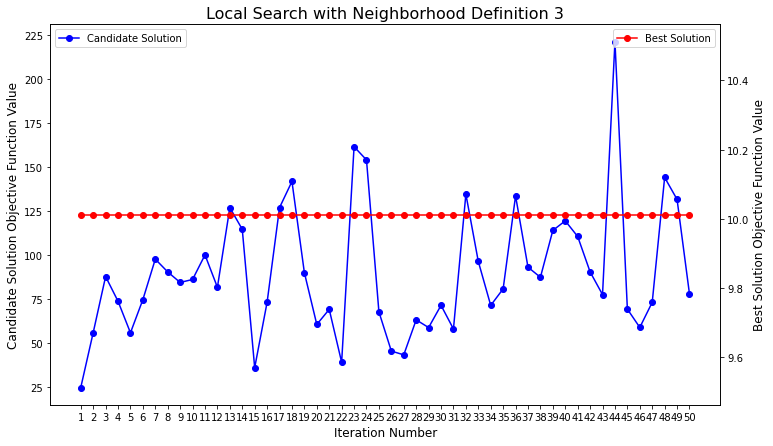

In [49]:
times, objectives, ngh, runs = [], [], [], []
for k in range(3,4):
    for i in range(1, n_run+1):
        print("neighborhood ", k, "run ", i)
        ngh.append(k)
        runs.append(i)
        local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
        local_search_average.run(which_neighbor=k)
        times.append(local_search_average.time)
        objectives.append(local_search_average.best_value)
        local_search_average.plot_ls(k, which_run=i)

In [50]:
Res = pd.DataFrame(columns=['Neighborhood','Run_n','BestObj','Time'])
Res['Neighborhood'] = ngh
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/local_search_w_different_ngh.xlsx")

In [51]:
print(x)

NameError: name 'x' is not defined

## 2. SA with selected neighborhood

In [ ]:
selected_neighborhood = 1 # later to be changed

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
    simulated_annealing_average.run(which_neighbor=selected_neighborhood)
    times.append(simulated_annealing_average.time)
    objectives.append(simulated_annealing_average.best_value)
    simulated_annealing_average.plot_sa(selected_neighborhood, which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/simulated_annealing_w_selected_ngh.xlsx")

## 3. VNS

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    vns_average = VNS(rg_, init_sol, n_iteration, "average")
    vns_average.run()
    times.append(vns_average.time)
    objectives.append(vns_average.best_value)
    vns_average.plot_vns(which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/vns.xlsx")

## 4. Local Search with Random Initial Solution

In [ ]:
init_sol = getRandomFeasibleSolution("average")

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    local_search_average = LocalSearch(rg_, init_sol, n_iteration, wt_obj='average')
    local_search_average.run(which_neighbor=selected_neighborhood)
    times.append(local_search_average.time)
    objectives.append(local_search_average.best_value)
    local_search_average.plot_ls(selected_neighborhood, which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_local_search_w_selected_ngh.xlsx")

## 5. Simulated Annealing with Random Initial Solution

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    simulated_annealing_average = SimulatedAnnealing(rg_, init_sol, n_iteration, "average")
    simulated_annealing_average.run(which_neighbor=selected_neighborhood)
    times.append(simulated_annealing_average.time)
    objectives.append(simulated_annealing_average.best_value)
    simulated_annealing_average.plot_sa(selected_neighborhood, which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_simulated_annealing_w_selected_ngh.xlsx")

## 6. VNS with Random Initial Solution

In [ ]:
times, objectives, runs = [], [], []
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    vns_average = VNS(rg_, init_sol, n_iteration, "average")
    vns_average.run()
    times.append(vns_average.time)
    objectives.append(vns_average.best_value)
    vns_average.plot_vns(which_run=i, randomm_init_sol=True)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','BestObj','Time'])
Res['Run_n'] = runs
Res['BestObj'] = objectives
Res['Time'] = times
Res.to_excel("excel_files/rnd_vns.xlsx")

## 7. Multi-Objective Local Search & VNS

In [ ]:
init_sol = constructionHeuristic("average")

In [ ]:
times_LS, times_VNS, SM_LS, SM_VNS, Dm_LS, Dm_VNS, QM_LS, QM_VNS, runs = [], [], [], [], [], [], [],[],[]
for i in range(1, n_run+1):
    print("run ", i)
    runs.append(i)
    
    local_search_multi = LocalSearchMultiObj(rg_, init_sol, n_iteration,wt_obj="average")
    local_search_multi.run(which_neighbor=selected_neighborhood)
    times_LS.append(local_search_multi.time)
    sm_, dm_ = SM_DM(local_search_multi)
    SM_LS.append(sm_)
    Dm_LS.append(dm_)
    
    vns_multi = VNSMultiObj(rg_, init_sol, n_iteration,wt_obj="average")
    vns_multi.run()
    times_VNS.append(local_search_multi.time)
    sm_, dm_ = SM_DM(vns_multi)
    SM_VNS.append(sm_)
    Dm_VNS.append(dm_)
    
    ls_QM, vns_QM = QM(local_search_multi,vns_multi)
    QM_LS.append(ls_QM)
    QM_VNS.append(vns_QM)
    
    local_search_multi.plot(which_neighbor=selected_neighborhood, which_run=i)
    vns_multi.plot(which_run=i)

In [ ]:
Res = pd.DataFrame(columns=['Run_n','LS_SM','LS_DM','LS_QM','LS_Time','VNS_SM','VNS_DM','VNS_QM','VNS_Time'])
Res['Run_n'] = runs
Res['LS_SM'] = SM_LS
Res['LS_DM'] = Dm_LS
Res['LS_QM'] = QM_LS
Res['LS_Time'] = times_LS
Res['VNS_SM'] = SM_VNS
Res['VNS_DM'] = Dm_VNS
Res['VNS_QM'] = QM_VNS
Res['VNS_Time'] = times_VNS
Res.to_excel("excel_files/multiobjective.xlsx")